In [1]:
# Import modules
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress, t

## Read in the AR Catalog

In [2]:

# Load AR catalog data with correct encoding
ar_data = pd.read_csv(
    r"C:\Users\brand\Documents\School Files\UIUC Courses\ATMS_596\Semester 2 - Spring 25\Data\ARcatalog_NCEP_NEW_1948-2018_Comprehensive_FINAL_29JAN18.csv",
    encoding="ISO-8859-1"
)


# Drop unnecessary columns and convert to xarray
ar_data['Date'] = pd.to_datetime(ar_data[['Year', 'Month']].astype(str).agg('-'.join, axis=1))
ar_data = ar_data.drop(columns=['Day', 'Hour'])
ar_catalog = xr.Dataset(
    {
        'Coastal_latitude': (['time'], ar_data['Coastal latitude of the landfalling AR (at AR center)'].values),
        'Coastal_longitude': (['time'], ar_data['Coastal longitude of the landfalling AR'].values),
        'IVT': (['time'], ar_data['IVT at landfall grid point'].values),
        'IWTv': (['time'], ar_data['IWTv at landfall grid point'].values),
        'UVTu': (['time'], ar_data['UVTu at landfall grid point'].values),
        'IWV': (['time'], ar_data['IWV'].values),
        'U_component': (['time'], ar_data['U component of wind over the landfall grid point'].values),
        'V_component': (['time'], ar_data['V component of wind over the landfall grid point'].values),
    },
    coords={
        'time': ar_data['Date'].values,
        'AR_ID': ar_data['AR ID'].values
    }
)

# Convert the time coordinate to a Pandas DatetimeIndex
ar_catalog['time'] = pd.to_datetime(ar_catalog['time'].values)


C:\Users\brand\AppData\Local\Temp\ipykernel_18324\2169567644.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  ar_data = pd.read_csv(


In [3]:
ar_catalog

<xarray.Dataset> Size: 3MB
Dimensions:            (time: 35154, AR_ID: 35154)
Coordinates:
  * time               (time) datetime64[ns] 281kB 1948-01-01 ... 2018-01-01
  * AR_ID              (AR_ID) int64 281kB 1 1 1 1 1 ... 4247 4247 4247 4247
Data variables:
    Coastal_latitude   (time) float64 281kB 45.0 45.0 40.0 ... 42.5 40.0 40.0
    Coastal_longitude  (time) float64 281kB 237.5 237.5 237.5 ... 237.5 237.5
    IVT                (time) float64 281kB 304.0 391.8 275.6 ... 383.4 331.9
    IWTv               (time) float64 281kB 196.8 173.1 121.9 ... 297.1 188.5
    UVTu               (time) float64 281kB 231.7 351.5 247.2 ... 242.3 273.2
    IWV                (time) float64 281kB 18.5 19.9 17.3 ... 16.7 16.2 15.3
    U_component        (time) float64 281kB 9.7 14.1 9.1 10.7 ... 9.4 5.3 10.2
    V_component        (time) float64 281kB 13.8 10.1 8.6 5.5 ... 11.4 8.4 5.2

## Map showing area of interest and latitude bands

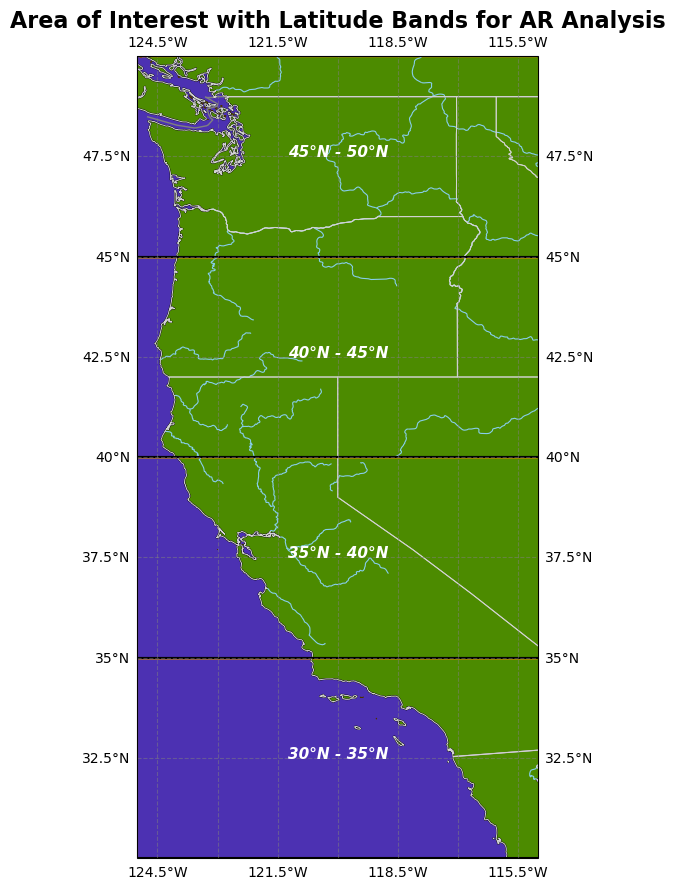

In [4]:


# Define the area of interest (e.g., U.S. West Coast)
min_lon, max_lon = -125, -115  # Longitude range (West Coast of the U.S.)
min_lat, max_lat = 30, 50  # Latitude range 

# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the extent of the map
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add higher resolution natural features to the map (e.g., land, oceans, rivers)
ax.add_feature(cfeature.LAND, facecolor='green', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='blue', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.2)
ax.add_feature(cfeature.RIVERS, edgecolor='skyblue', linewidth=0.8)

# Add state boundaries with thinner lines
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.7)

# Add gridlines with a subtle style
ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.5)

# Latitude Bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Plot latitude bands (shaded areas)
for band in latitude_bands:
    ax.fill_betweenx(
        [band[0], band[1]], min_lon, max_lon, color='orange', alpha=0.3
    )
    # Add black lines to divide the latitude bands
    ax.plot([min_lon, max_lon], [band[0], band[0]], color='black', lw=1.5)  # Top line
    ax.plot([min_lon, max_lon], [band[1], band[1]], color='black', lw=1.5)  # Bottom line

# Add labels to the latitude bands with white font
for band in latitude_bands:
    ax.text(
        -120, (band[0] + band[1]) / 2, f"{band[0]}°N - {band[1]}°N", 
        fontsize=11, ha='center', color='white', fontweight='bold', 
        style='italic'
    )

# Add a title to the map
ax.set_title("Area of Interest with Latitude Bands for AR Analysis", fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap and make the map more spacious
plt.tight_layout()

# Show the plot
plt.show()


# ______________________________________________________________________________________________________

# Analyze IVT, latitude, and wind components of observed AR's from 1950 to present

### AR Counts over time

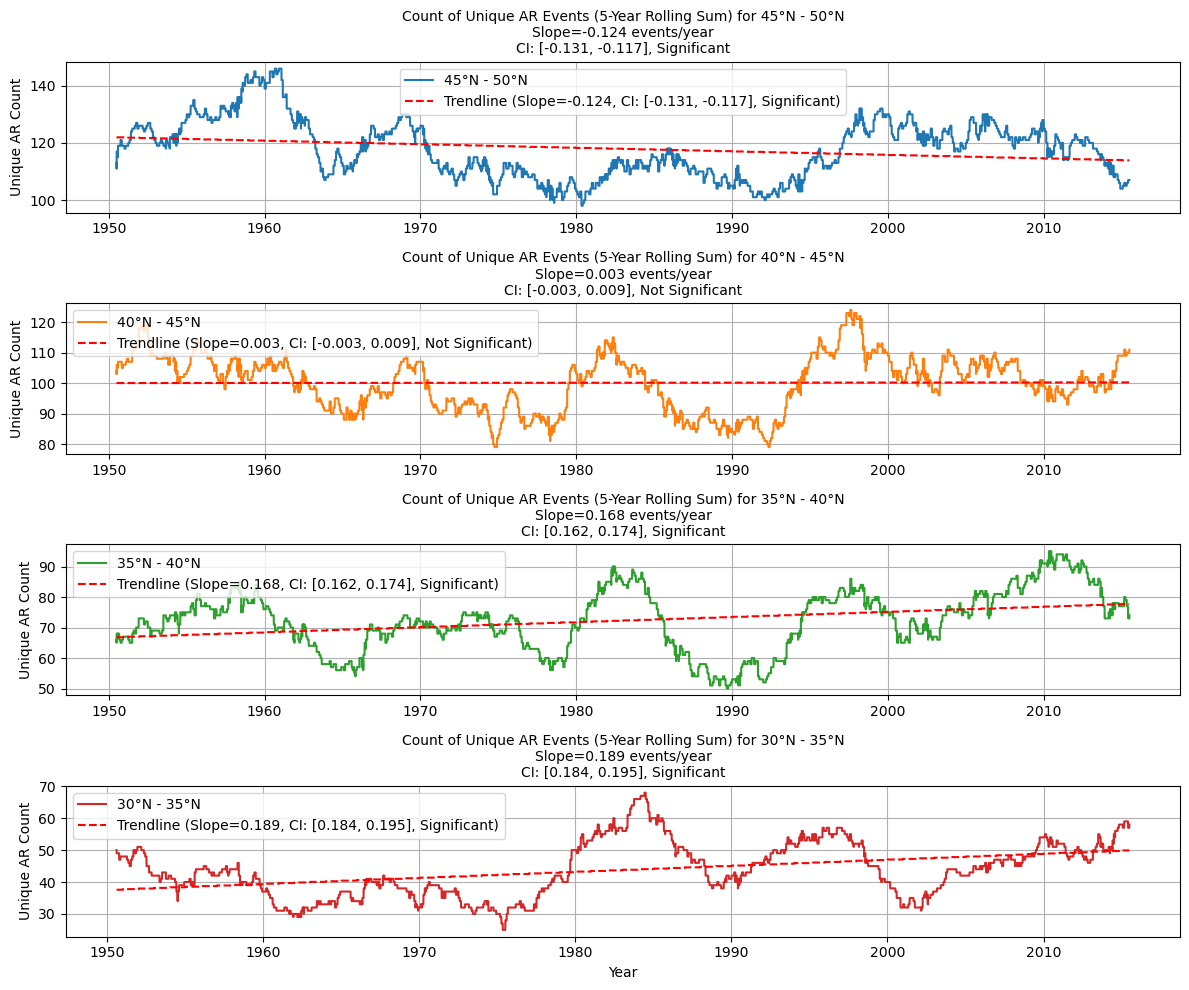

In [5]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ar_id = ar_catalog['AR_ID'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands and calculate rolling unique AR_ID counts
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract data for the latitude band
    band_time = time[mask]
    band_ar_id = ar_id[mask]
    
    # Create a DataFrame for grouping by day
    band_df = pd.DataFrame({'time': band_time, 'AR_ID': band_ar_id}).drop_duplicates()
    band_df.set_index('time', inplace=True)
    
    # Resample to daily frequency and count unique AR_IDs
    daily_unique_counts = band_df.resample('D').AR_ID.nunique()
    
    # Calculate the rolling sum of unique counts
    rolling_unique_counts = daily_unique_counts.rolling(window=window_size, center=True).sum()
    
    # Store data for plotting
    band_data.append((band, rolling_unique_counts.index, rolling_unique_counts.values))

# Plot the unique count of ARs for each latitude band with trendlines (reversed order)
plt.figure(figsize=(12, 10))

# Reverse the order of latitude bands for plotting
for i, (band, band_time, band_count) in enumerate(reversed(band_data)): 
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_count)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_count_valid = band_count[valid_idx]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(band_time_numeric, band_count_valid)
    
    # Calculate the 95% Confidence Interval for the slope
    n = len(band_count_valid)  # number of valid points
    t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
    margin_of_error = t_critical * std_err  # Margin of error for the slope
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
    
    # Plot the rolling count
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_count, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Plot the trendline
    trendline = slope * band_time_numeric + intercept
    plt.plot(band_time[valid_idx], trendline, color='red', linestyle='--', label=f'Trendline (Slope={slope:.3f}, CI: [{ci_lower:.3f}, {ci_upper:.3f}], {"Significant" if significant else "Not Significant"})')
    
    # Add title with slope value and CI info
    plt.title(f"Count of Unique AR Events (5-Year Rolling Sum) for {band[0]}°N - {band[1]}°N\nSlope={slope:.3f} events/year\nCI: [{ci_lower:.3f}, {ci_upper:.3f}], {'Significant' if significant else 'Not Significant'}", fontsize=10)
    plt.ylabel("Unique AR Count")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [6]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ar_id = ar_catalog['AR_ID'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling unique AR_ID counts
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract data for the latitude band
    band_time = time[mask]
    band_ar_id = ar_id[mask]
    
    # Create a DataFrame for grouping by day
    band_df = pd.DataFrame({'time': band_time, 'AR_ID': band_ar_id}).drop_duplicates()
    band_df.set_index('time', inplace=True)
    
    # Resample to daily frequency and count unique AR_IDs
    daily_unique_counts = band_df.resample('D').AR_ID.nunique()
    
    # Calculate the rolling sum of unique counts
    rolling_unique_counts = daily_unique_counts.rolling(window=window_size, center=True).sum()
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(rolling_unique_counts.values)
    band_time_numeric = pd.to_datetime(rolling_unique_counts.index[valid_idx]).year  # Convert time to numeric for regression
    band_count_valid = rolling_unique_counts.values[valid_idx]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(band_time_numeric, band_count_valid)
    
    # Calculate the 95% Confidence Interval for the slope
    n = len(band_count_valid)  # number of valid points
    t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
    margin_of_error = t_critical * std_err  # Margin of error for the slope
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
    
    # Store results in the dictionary
    results[f"{band[0]}°N-{band[1]}°N"] = {
        "Slope": slope,
        "CI_Lower": ci_lower,
        "CI_Upper": ci_upper,
        "Significant": significant
    }

# Print results
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Latitude Band: 30°N-35°N
  Slope: 0.189
  95% CI: [0.184, 0.195]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: 0.168
  95% CI: [0.162, 0.174]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.003
  95% CI: [-0.003, 0.009]
  Significant: No
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: -0.124
  95% CI: [-0.131, -0.117]
  Significant: Yes
--------------------------------------------------


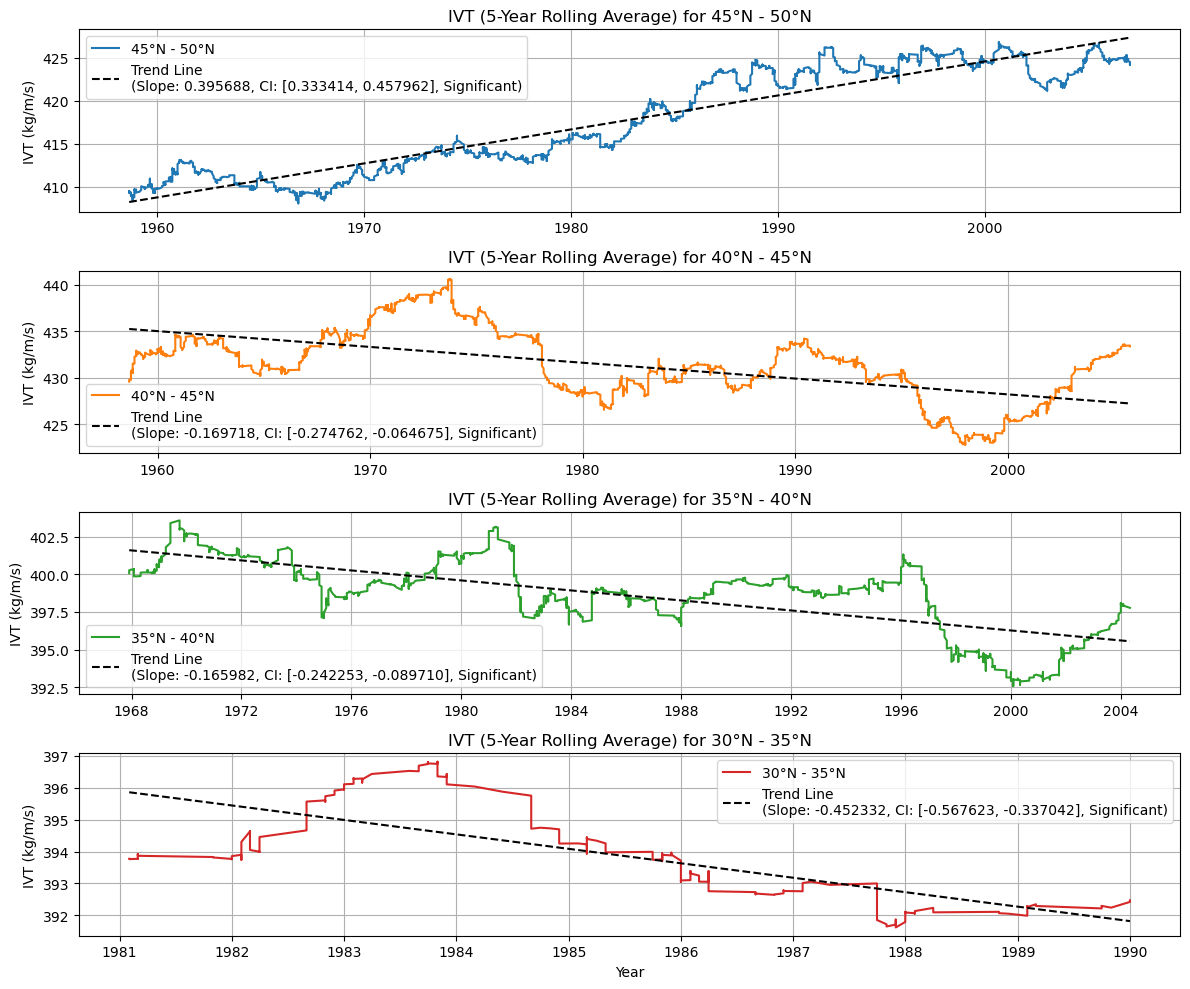

In [7]:
# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ivt = ar_catalog['IVT'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_ivt))

# Plot the IVT for each latitude band (in reversed order)
plt.figure(figsize=(12, 10))

# Reverse the order of latitude bands for plotting
for i, (band, band_time, band_ivt) in enumerate(reversed(band_data)):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_ivt, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_ivt)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_ivt[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"IVT (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("IVT (kg/m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [8]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ivt = ar_catalog['IVT'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}
band_data = []

# Group data into latitude bands and calculate rolling IVT
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and IVT for the latitude band
    band_time = time[mask]
    band_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
    band_data.append((band, band_time, band_ivt))
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_ivt.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_ivt_valid = band_ivt.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_ivt_valid, 1)
        residuals = band_ivt_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for IVT Trends by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)



Results for IVT Trends by Latitude Band
Latitude Band: 30°N-35°N
  Slope: -0.472
  95% CI: [-0.582, -0.362]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.166
  95% CI: [-0.242, -0.089]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: -0.169
  95% CI: [-0.274, -0.064]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.396
  95% CI: [0.333, 0.458]
  Significant: Yes
--------------------------------------------------


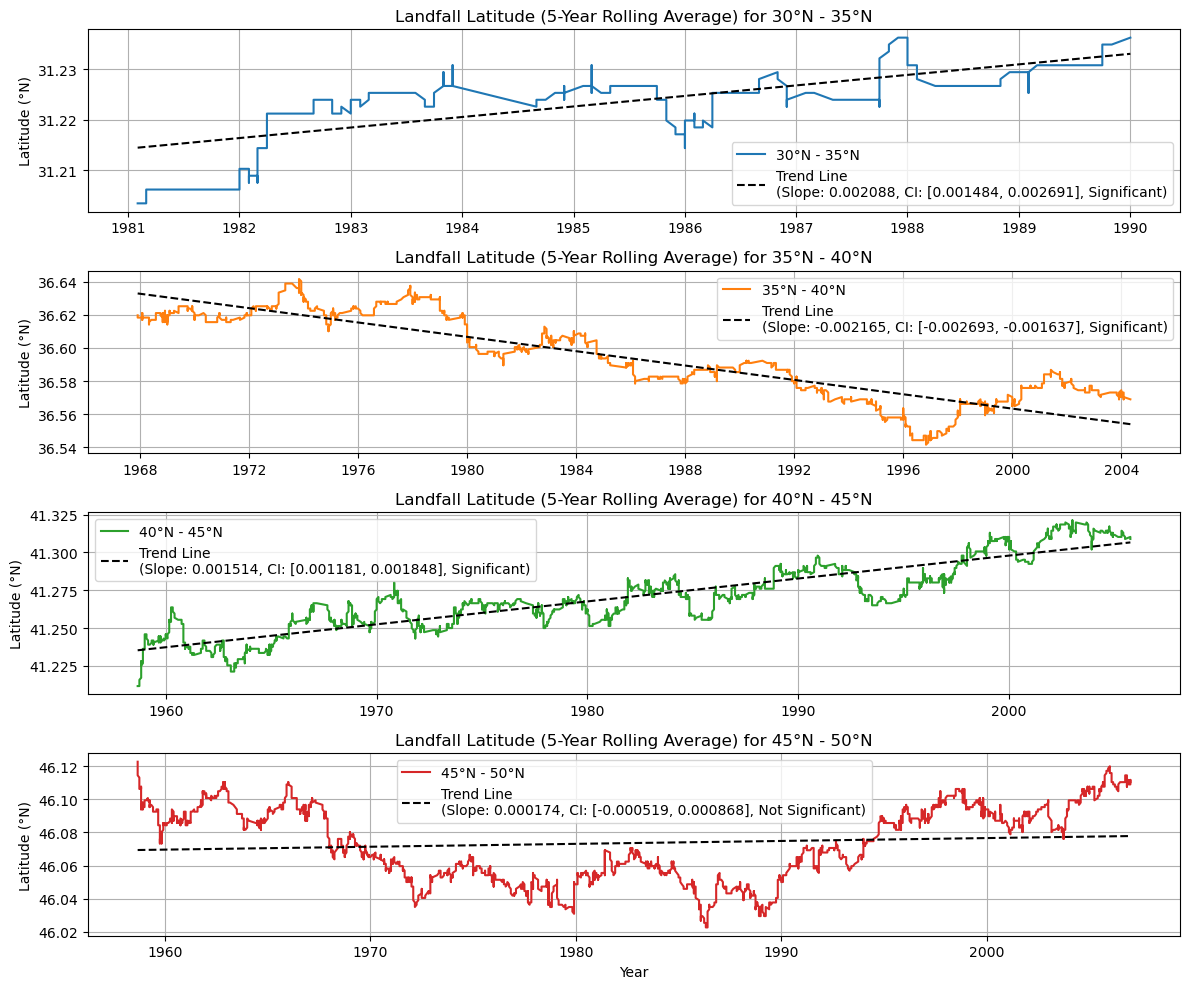

In [9]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_latitude = pd.Series(latitude[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_latitude))

# Plot the landfall latitude for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_latitude) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_latitude, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_latitude)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_latitude[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"Landfall Latitude (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("Latitude (°N)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [10]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}
band_data = []

# Group data into latitude bands and calculate rolling latitude averages
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and latitude for the latitude band
    band_time = time[mask]
    band_latitude = pd.Series(latitude[mask]).rolling(window=window_size, center=True).mean()
    band_data.append((band, band_time, band_latitude))
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_latitude.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_latitude_valid = band_latitude.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_latitude_valid, 1)
        residuals = band_latitude_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for Landfall Latitude Trends by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for Landfall Latitude Trends by Latitude Band
Latitude Band: 30°N-35°N
  Slope: 0.002
  95% CI: [0.001, 0.003]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.002
  95% CI: [-0.003, -0.002]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.002
  95% CI: [0.001, 0.002]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.000
  95% CI: [-0.001, 0.001]
  Significant: No
--------------------------------------------------


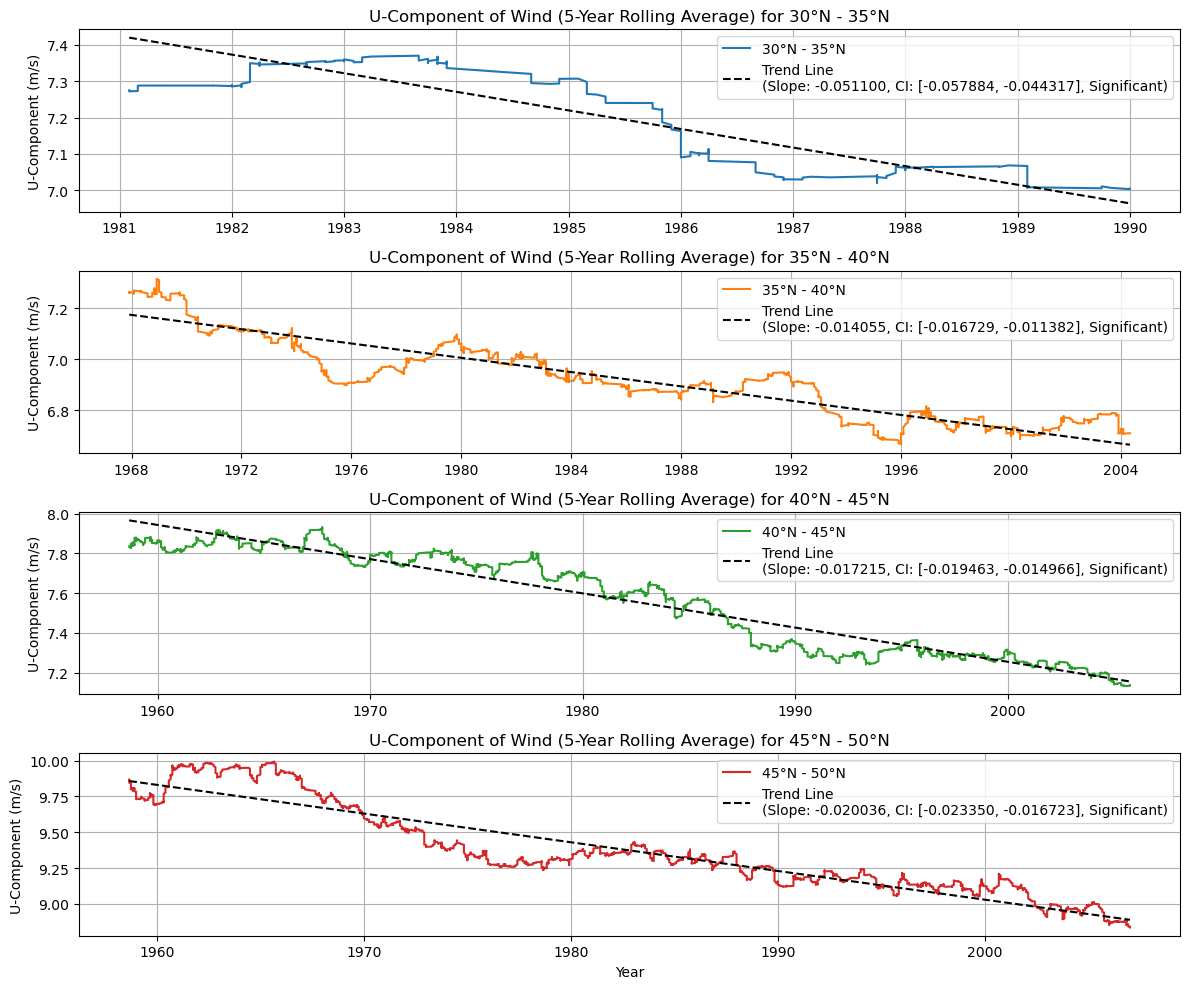

In [11]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
u_component = ar_catalog['U_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_u_component = pd.Series(u_component[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_u_component))

# Plot the U-Component of Wind for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_u_component) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_u_component, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_u_component)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_u_component[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"U-Component of Wind (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("U-Component (m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [12]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
u_component = ar_catalog['U_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling latitude averages for U-component
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and U-component for the latitude band
    band_time = time[mask]
    band_u_component = pd.Series(u_component[mask]).rolling(window=window_size, center=True).mean()

    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_u_component.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_u_component_valid = band_u_component.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_u_component_valid, 1)
        residuals = band_u_component_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for U-Component of Wind by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for U-Component of Wind by Latitude Band
Latitude Band: 30°N-35°N
  Slope: -0.052
  95% CI: [-0.058, -0.045]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.014
  95% CI: [-0.017, -0.011]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: -0.017
  95% CI: [-0.019, -0.015]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: -0.020
  95% CI: [-0.023, -0.017]
  Significant: Yes
--------------------------------------------------


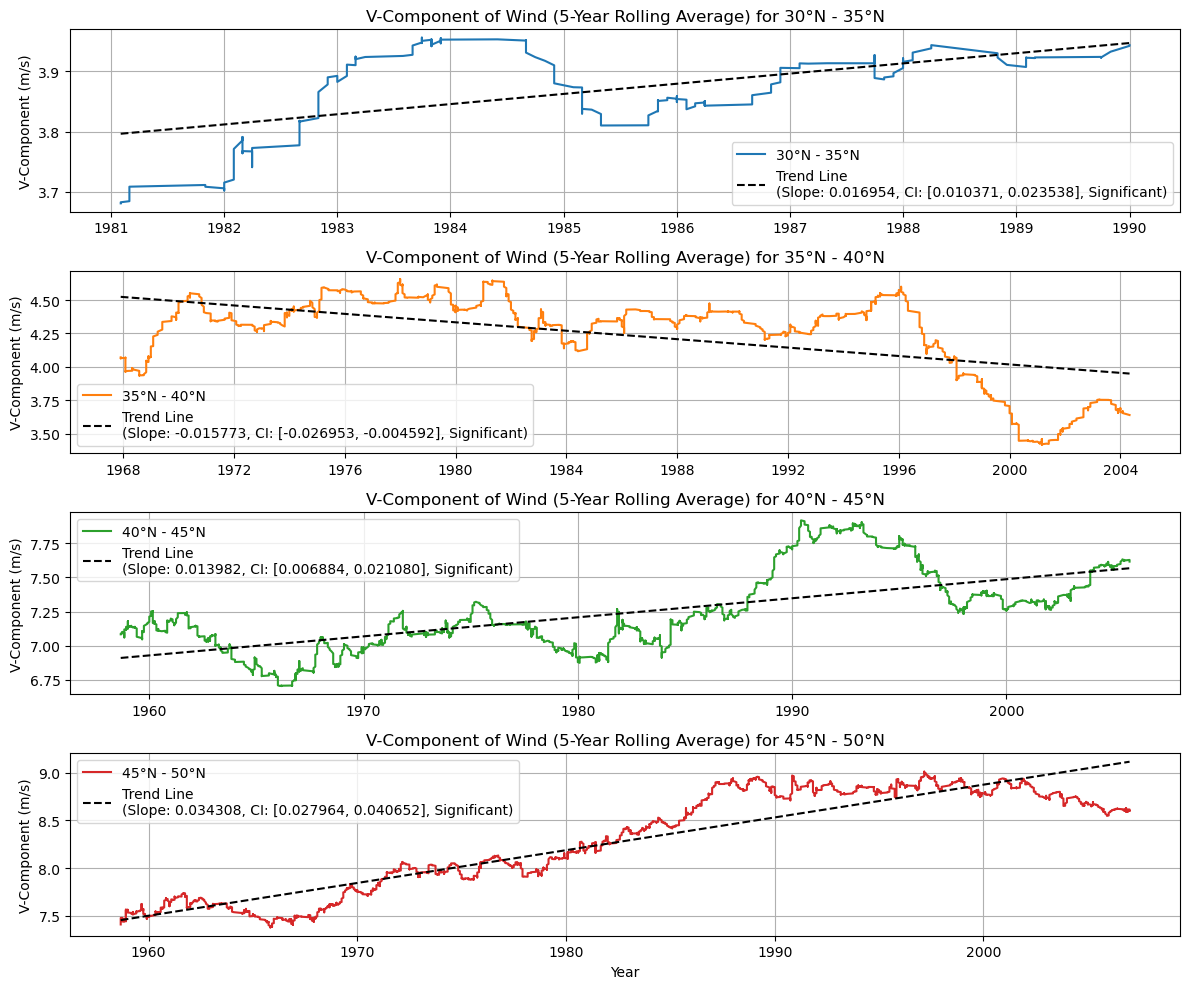

In [13]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
v_component = ar_catalog['V_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_v_component = pd.Series(v_component[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_v_component))

# Plot the V-Component of Wind for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_v_component) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_v_component, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_v_component)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_v_component[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"V-Component of Wind (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("V-Component (m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [14]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
v_component = ar_catalog['V_component'].values  # Use V-component instead of U-component
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling latitude averages for V-component
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and V-component for the latitude band
    band_time = time[mask]
    band_v_component = pd.Series(v_component[mask]).rolling(window=window_size, center=True).mean()

    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_v_component.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_v_component_valid = band_v_component.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_v_component_valid, 1)
        residuals = band_v_component_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for V-Component of Wind by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for V-Component of Wind by Latitude Band
Latitude Band: 30°N-35°N
  Slope: 0.015
  95% CI: [0.008, 0.022]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.016
  95% CI: [-0.027, -0.004]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.014
  95% CI: [0.007, 0.021]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.034
  95% CI: [0.028, 0.041]
  Significant: Yes
--------------------------------------------------


## Atmospheric River Category Trends

In [15]:
# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
ivt = ar_catalog['IVT'].values

# Define IVT categories
ivt_categories = [
    (250, 500),    # Category 1
    (500, 750),    # Category 2
    (750, 1000),   # Category 3
    (1000, 1250),  # Category 4
    (1250, np.inf) # Category 5
]

for i, category in enumerate(ivt_categories):
    mask = (ivt >= category[0]) & (ivt < category[1])
    print(f"Category {i + 1}: {category[0]}-{category[1]} IVT -> {np.sum(mask)} data points")


Category 1: 250-500 IVT -> 27888 data points
Category 2: 500-750 IVT -> 6669 data points
Category 3: 750-1000 IVT -> 555 data points
Category 4: 1000-1250 IVT -> 40 data points
Category 5: 1250-inf IVT -> 2 data points


In [16]:
mask = (ivt >= 750) & (ivt < 1000)  # Category 3 example
rolling_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
print("Rolling IVT for Category 3:", rolling_ivt[:10])


Rolling IVT for Category 3: 0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
dtype: float64


C:\Users\brand\AppData\Local\Temp\ipykernel_18324\4105641998.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((x_valid - np.mean(x_valid))**2))


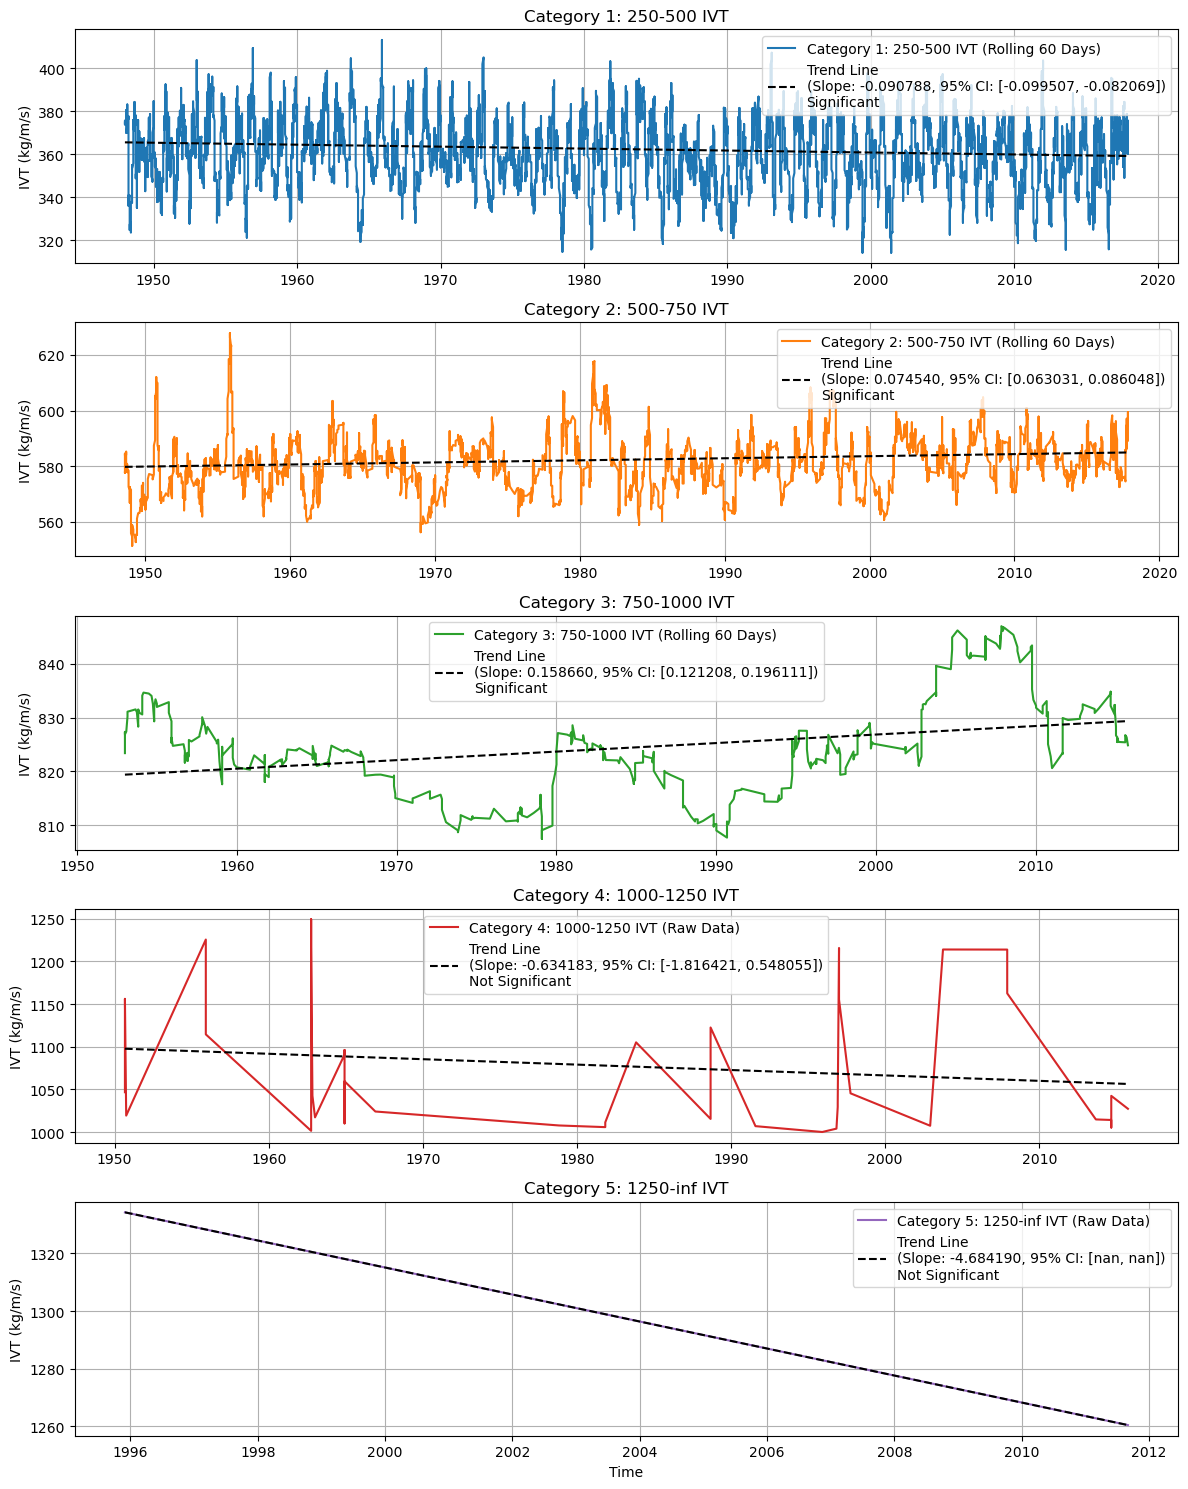

In [17]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
ivt = ar_catalog['IVT'].values

# Define IVT categories
ivt_categories = [
    (250, 500),    # Category 1
    (500, 750),    # Category 2
    (750, 1000),   # Category 3
    (1000, 1250),  # Category 4
    (1250, np.inf) # Category 5
]

# Define the rolling window size for the first 3 categories (60 days)
rolling_window = 60

plt.figure(figsize=(12, 15))

# Loop over each IVT category and plot the time series with rolling window for categories 1-3
for i, category in enumerate(ivt_categories):
    mask = (ivt >= category[0]) & (ivt < category[1])
    category_time = time[mask]
    category_ivt = ivt[mask]

    # Skip plotting if no data exists for the category
    if np.sum(mask) == 0:
        print(f"No data for Category {i + 1}: {category[0]}-{category[1]} IVT")
        continue
    
    # Apply rolling window only to the first 3 categories
    if i < 3:  # Apply 60-day rolling for Category 1, 2, and 3
        category_ivt = pd.Series(category_ivt).rolling(window=rolling_window, center=True).mean()
        label_suffix = f"(Rolling {rolling_window} Days)"
    else:
        label_suffix = "(Raw Data)"  # No rolling for Categories 4 and 5
    
    # Plot the smoothed or raw data
    plt.subplot(len(ivt_categories), 1, i + 1)
    plt.plot(category_time, category_ivt, label=f"Category {i + 1}: {category[0]}-{category[1]} IVT {label_suffix}", color=f"C{i}")
    
    # Calculate and plot trendline with confidence interval
    valid_mask = ~np.isnan(category_ivt)
    if valid_mask.any():
        x_valid = pd.to_numeric(category_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = category_ivt[valid_mask]
        
        # Fit the trendline (linear regression)
        slope, intercept = np.polyfit(x_valid, y_valid, 1)

        # Calculate residuals and standard error of the slope
        y_pred = slope * x_valid + intercept
        residuals = y_valid - y_pred
        residual_sum_of_squares = np.sum(residuals**2)
        degrees_of_freedom = len(x_valid) - 2
        standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((x_valid - np.mean(x_valid))**2))
        
        # Calculate the t-statistic and p-value
        t_stat = slope / standard_error
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), degrees_of_freedom))  # Two-tailed test
        
        # Calculate the 95% confidence interval for the slope
        t_critical = stats.t.ppf(1 - 0.025, df=degrees_of_freedom)  # 95% confidence, two-tailed
        margin_of_error = t_critical * standard_error  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        
        # Determine if trend is significant
        if p_value < 0.05:
            significance_label = "Significant"
        else:
            significance_label = "Not Significant"
        
        # Plot the trendline
        plt.plot(
            category_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, 95% CI: [{ci_lower:.6f}, {ci_upper:.6f}])\n{significance_label}"
        )

    # Adding the title, grid, and legend
    plt.title(f"Category {i + 1}: {category[0]}-{category[1]} IVT")
    plt.ylabel("IVT (kg/m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()






In [18]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
ivt = ar_catalog['IVT'].values

# Define IVT categories
ivt_categories = [
    (250, 500),    # Category 1
    (500, 750),    # Category 2
    (750, 1000),   # Category 3
    (1000, 1250),  # Category 4
    (1250, np.inf) # Category 5
]

# Define the rolling window size for the first 3 categories (60 days)
rolling_window = 60

# Create a dictionary to store results
results = {}

# Loop over each IVT category
for i, category in enumerate(ivt_categories):
    # Mask to filter data within the category
    mask = (ivt >= category[0]) & (ivt < category[1])
    category_time = time[mask]
    category_ivt = ivt[mask]

    # Apply rolling mean for the first 3 categories
    if i < 3:
        category_ivt = pd.Series(category_ivt).rolling(window=rolling_window, center=True).mean().to_numpy()
    
    # Remove NaN values for regression
    valid_mask = ~np.isnan(category_ivt)
    if valid_mask.sum() == 0:  # Skip if no valid data points
        print(f"No data available for Category {i + 1}: {category[0]}-{category[1]} IVT")
        continue
    
    category_time_valid = category_time[valid_mask]
    category_ivt_valid = category_ivt[valid_mask]  # Already a numpy array
    category_time_numeric = pd.to_numeric(category_time_valid) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years

    # Perform linear regression
    slope, intercept = np.polyfit(category_time_numeric, category_ivt_valid, 1)
    y_pred = slope * category_time_numeric + intercept

    # Calculate residuals and standard error
    residuals = category_ivt_valid - y_pred
    residual_sum_of_squares = np.sum(residuals**2)
    degrees_of_freedom = len(category_time_numeric) - 2
    standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((category_time_numeric - np.mean(category_time_numeric))**2))

    # Calculate the 95% confidence interval for the slope
    t_critical = t.ppf(1 - 0.025, df=degrees_of_freedom)
    margin_of_error = t_critical * standard_error
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error

    # Check significance
    significant = ci_lower > 0 or ci_upper < 0

    # Store results in the dictionary
    results[f"Category {i + 1}: {category[0]}-{category[1]} IVT"] = {
        "Slope": slope,
        "CI_Lower": ci_lower,
        "CI_Upper": ci_upper,
        "Significant": significant
    }

# Print results
print("Results for IVT Categories")
print("=" * 50)
for category, metrics in results.items():
    print(f"{category}")
    print(f"  Slope: {metrics['Slope']:.6f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.6f}, {metrics['CI_Upper']:.6f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for IVT Categories
Category 1: 250-500 IVT
  Slope: -0.090788
  95% CI: [-0.099507, -0.082069]
  Significant: Yes
--------------------------------------------------
Category 2: 500-750 IVT
  Slope: 0.074540
  95% CI: [0.063031, 0.086048]
  Significant: Yes
--------------------------------------------------
Category 3: 750-1000 IVT
  Slope: 0.158660
  95% CI: [0.121208, 0.196111]
  Significant: Yes
--------------------------------------------------
Category 4: 1000-1250 IVT
  Slope: -0.634183
  95% CI: [-1.816421, 0.548055]
  Significant: No
--------------------------------------------------
Category 5: 1250-inf IVT
  Slope: -4.684190
  95% CI: [nan, nan]
  Significant: No
--------------------------------------------------


C:\Users\brand\AppData\Local\Temp\ipykernel_18324\501881866.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((category_time_numeric - np.mean(category_time_numeric))**2))


# _______________________________________________________________________________________________________

# Precipitation Analysis

# ____________________________________________________________________________________________

## Load and Process Precipitation Data

In [19]:

# Import modules
import os
import numpy as np
import pandas as pd
import xarray as xr

# Load Precipitation Files
data_dir = r"C:\Users\brand\Documents\School Files\UIUC Courses\ATMS_596\Semester 2 - Spring 25\Data"
file_list = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("precip.V1.0.") and f.endswith(".nc")])
print(f"Found {len(file_list)} files.")

# Combine Datasets
ds_all = xr.open_mfdataset(file_list, combine='by_coords')

# Subset West Coast Domain 
ds_westcoast = ds_all.sel(lat=slice(32, 49.5), lon=slice(235, 245))
print(ds_westcoast)


Found 56 files.
<xarray.Dataset> Size: 229MB
Dimensions:  (time: 20454, lat: 70, lon: 40)
Coordinates:
  * lat      (lat) float32 280B 32.12 32.38 32.62 32.88 ... 48.88 49.12 49.38
  * lon      (lon) float32 160B 235.1 235.4 235.6 235.9 ... 244.4 244.6 244.9
  * time     (time) datetime64[ns] 164kB 1960-01-01 1960-01-02 ... 2015-12-31
Data variables:
    precip   (time, lat, lon) float32 229MB dask.array<chunksize=(1, 70, 40), meta=np.ndarray>
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created V1.0 starting 04/2010 by CAS from data...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...


## Load and Process AR Catalog

In [20]:

import pandas as pd
import xarray as xr

# Load CSV file
file_path = r"C:\Users\brand\Documents\School Files\UIUC Courses\ATMS_596\Semester 2 - Spring 25\Data\ARcatalog_NCEP_NEW_1948-2018_Comprehensive_FINAL_29JAN18.csv"
ar_data = pd.read_csv(file_path, encoding="ISO-8859-1")


# Convert longitude from 0-360 to -180 to 180 if needed
ar_data['Coastal longitude of the landfalling AR'] = ar_data['Coastal longitude of the landfalling AR'].apply(lambda lon: lon - 360 if lon > 180 else lon)

# Create a DateTime column
ar_data['Date'] = pd.to_datetime(ar_data[['Year', 'Month', 'Day', 'Hour']])

# Convert to xarray Dataset
ar_catalog = xr.Dataset(
    {
        'Coastal_latitude': (['time'], ar_data['Coastal latitude of the landfalling AR (at AR center)'].values),
        'Coastal_longitude': (['time'], ar_data['Coastal longitude of the landfalling AR'].values),
        'IVT': (['time'], ar_data['IVT at landfall grid point'].values),
        'IWTv': (['time'], ar_data['IWTv at landfall grid point'].values),
        'UVTu': (['time'], ar_data['UVTu at landfall grid point'].values),
        'IWV': (['time'], ar_data['IWV'].values),
        'U_component': (['time'], ar_data['U component of wind over the landfall grid point'].values),
        'V_component': (['time'], ar_data['V component of wind over the landfall grid point'].values),
    },
    coords={
        'time': ar_data['Date'].values,
        'AR_ID': ar_data['AR ID'].values
    }
)

# Extract Year, Month, Day, and Hour as coordinates
ar_catalog = ar_catalog.assign_coords(
    Year=('time', ar_data['Year'].values),
    Month=('time', ar_data['Month'].values),
    Day=('time', ar_data['Day'].values),
    Hour=('time', ar_data['Hour'].values)
)

# Print adjusted dataset information
print(ar_catalog)
# Sort AR catalog by time (important for slicing)
ar_catalog_sorted = ar_catalog.sortby('time')

# Now filter to 1960–2015
ar_catalog_filtered = ar_catalog_sorted.sel(time=slice('1960-01-01', '2015-12-31'))

# Filter ARs to coastal landfalls within CA/OR/WA region
ar_catalog_filtered = ar_catalog_filtered.where(
    (ar_catalog_filtered['Coastal_latitude'] >= 32) & 
    (ar_catalog_filtered['Coastal_latitude'] <= 49.5) &
    (ar_catalog_filtered['Coastal_longitude'] >= -125) & 
    (ar_catalog_filtered['Coastal_longitude'] <= -115),
    drop=True
)

# Print number of events
print(f"Number of AR events after filtering: {ar_catalog_filtered.sizes['time']}")


ar_catalog_filtered


<xarray.Dataset> Size: 4MB
Dimensions:            (time: 35154, AR_ID: 35154)
Coordinates:
  * time               (time) datetime64[ns] 281kB 1948-01-01T18:00:00 ... 20...
  * AR_ID              (AR_ID) int64 281kB 1 1 1 1 1 ... 4247 4247 4247 4247
    Year               (time) int64 281kB 1948 1948 1948 1948 ... 2018 2018 2018
    Month              (time) int64 281kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    Day                (time) int64 281kB 1 2 2 2 2 3 3 ... 17 17 18 18 18 18 19
    Hour               (time) int64 281kB 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0
Data variables:
    Coastal_latitude   (time) float64 281kB 45.0 45.0 40.0 ... 42.5 40.0 40.0
    Coastal_longitude  (time) float64 281kB -122.5 -122.5 ... -122.5 -122.5
    IVT                (time) float64 281kB 304.0 391.8 275.6 ... 383.4 331.9
    IWTv               (time) float64 281kB 196.8 173.1 121.9 ... 297.1 188.5
    UVTu               (time) float64 281kB 231.7 351.5 247.2 ... 242.3 273.2
    IWV                (

C:\Users\brand\AppData\Local\Temp\ipykernel_18324\2114982277.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  ar_data = pd.read_csv(file_path, encoding="ISO-8859-1")


<xarray.Dataset> Size: 2MB
Dimensions:            (time: 12085, AR_ID: 35154)
Coordinates:
  * time               (time) datetime64[ns] 97kB 1960-01-07 ... 2015-12-23T0...
  * AR_ID              (AR_ID) int64 281kB 1 1 1 1 1 ... 4247 4247 4247 4247
    Year               (time) int64 97kB 1960 1960 1960 1960 ... 2015 2015 2015
    Month              (time) int64 97kB 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
    Day                (time) int64 97kB 7 7 7 7 8 21 21 ... 21 22 22 22 22 23
    Hour               (time) int64 97kB 0 6 12 18 0 6 12 ... 12 18 0 6 12 18 6
Data variables:
    Coastal_latitude   (time) float64 97kB 40.0 40.0 40.0 ... 37.5 32.5 35.0
    Coastal_longitude  (time) float64 97kB -122.5 -122.5 ... -117.5 -120.0
    IVT                (time) float64 97kB 264.7 344.4 283.6 ... 591.1 368.7
    IWTv               (time) float64 97kB -36.7 -12.16 38.73 ... -313.5 -239.0
    UVTu               (time) float64 97kB 262.1 344.2 281.0 ... 501.2 280.7
    IWV                (time) float64 97kB 18.9 21.3 19.2 ... 31.4 29.8 16.1
    U_component        (time) float64 97kB 6.6 9.2 7.5 8.7 ... 19.5 16.1 7.5
    V_component        (time) float64 97kB 0.4 1.4 2.0 7.0 ... -10.5 -8.8 -9.4

## Match Precipitation to AR Days

In [21]:

# AR Event Dates
ar_dates = pd.to_datetime(ar_catalog_filtered['time'].values).normalize()
ar_dates_unique = np.unique(ar_dates)
print(f"Number of unique AR dates: {len(ar_dates_unique)}")

# Select Matching Precip Days
precip_ar_days = ds_westcoast.sel(time=ar_dates_unique)
print(precip_ar_days)


Number of unique AR dates: 4717
<xarray.Dataset> Size: 53MB
Dimensions:  (time: 4717, lat: 70, lon: 40)
Coordinates:
  * lat      (lat) float32 280B 32.12 32.38 32.62 32.88 ... 48.88 49.12 49.38
  * lon      (lon) float32 160B 235.1 235.4 235.6 235.9 ... 244.4 244.6 244.9
  * time     (time) datetime64[ns] 38kB 1960-01-07 1960-01-08 ... 2015-12-23
Data variables:
    precip   (time, lat, lon) float32 53MB dask.array<chunksize=(1, 70, 40), meta=np.ndarray>
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    history:        originally created V1.0 starting 04/2010 by CAS from data...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...


## Average Precipitation Analysis

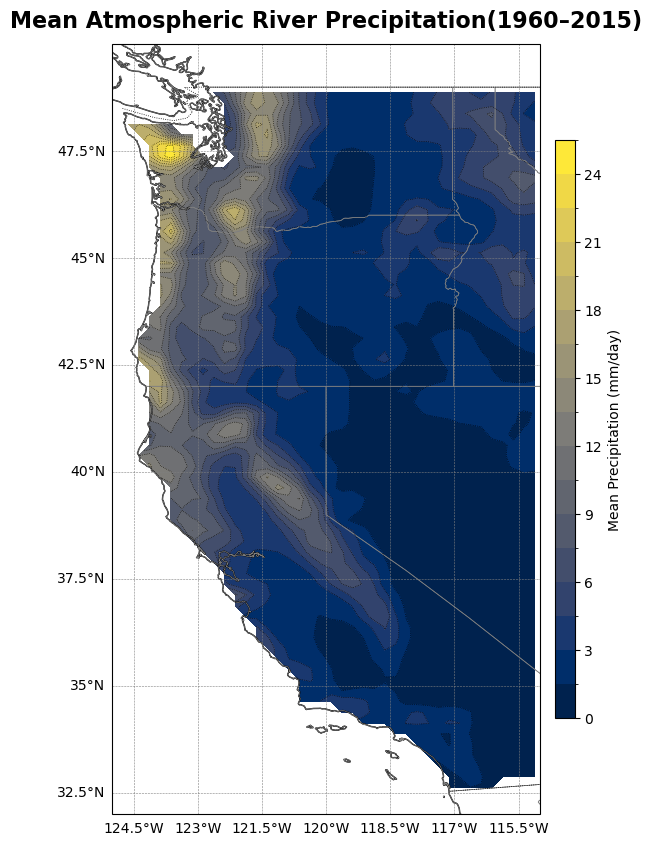

In [22]:

import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Compute mean AR-day precipitation over time
mean_precip_ar = precip_ar_days['precip'].mean(dim='time')

# Use Natural Earth v5.0.0 land polygons at 1:110m scale
land_regions = regionmask.defined_regions.natural_earth_v5_0_0.land_110

# Apply land mask to mean precipitation
land_mask = land_regions.mask(mean_precip_ar)

# Mask to land-only grid cells
mean_precip_land_only = mean_precip_ar.where(~np.isnan(land_mask))

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Base filled contour
contourf = mean_precip_land_only.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='cividis',
    levels=20,             # 20 smooth levels
    add_colorbar=False     # We'll add it separately
)

# Line contours on top
contour = mean_precip_land_only.plot.contour(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=20,             # Fewer lines for clarity
    linewidths=0.5,
    colors='black',
    linestyles='dotted',
    add_labels=False,
    add_colorbar=False
)

# Add colorbar
cbar = plt.colorbar(contourf, ax=ax, shrink=0.75, aspect=30, pad=0.02)
cbar.set_label("Mean Precipitation (mm/day)")

# Add map features
ax.set_extent([-125, -115, 32, 50])
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.4, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title("Mean Atmospheric River Precipitation(1960–2015)", fontsize=16, fontweight='bold', pad=12)

plt.show()



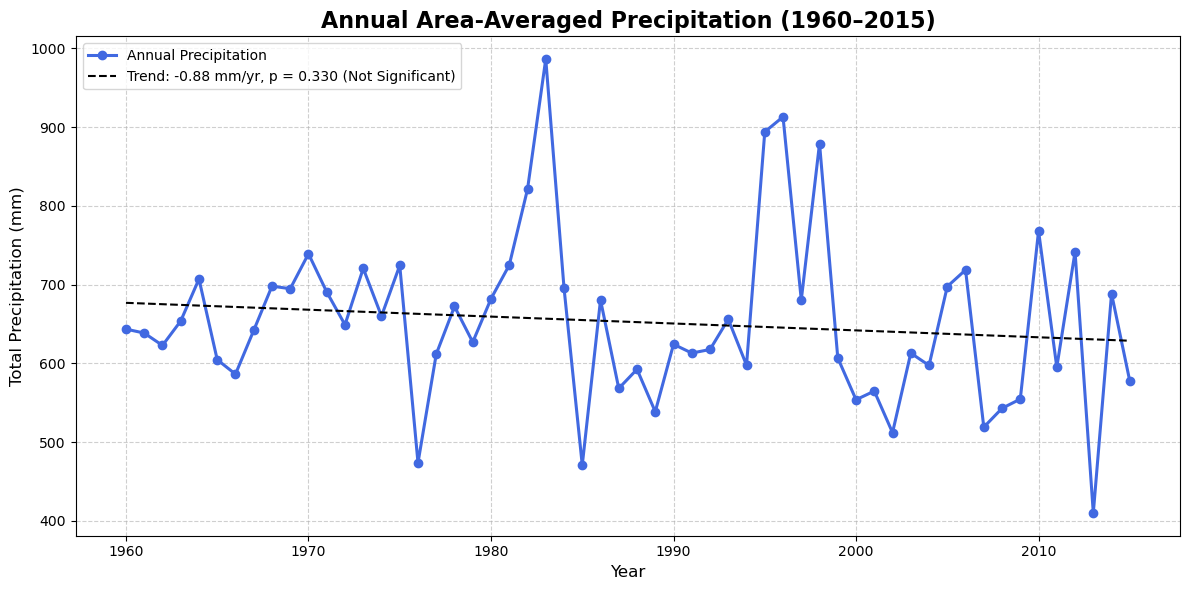

In [23]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Area-averaged daily precipitation over entire West Coast
precip_all_mean = ds_westcoast['precip'].mean(dim=['lat', 'lon'])

# Annual totals
precip_all_annual = precip_all_mean.groupby('time.year').sum(dim='time').compute()
years = precip_all_annual['year'].values
values = precip_all_annual.values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, values)
trend_line = intercept + slope * years
sig_label = "Significant" if p_value < 0.05 else "Not Significant"

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, values, marker='o', color='royalblue', linewidth=2.2, label='Annual Precipitation')
plt.plot(years, trend_line, linestyle='--', color='black',
         label=f"Trend: {slope:.2f} mm/yr, p = {p_value:.3f} ({sig_label})")

# Plot Formatting
plt.title("Annual Area-Averaged Precipitation (1960–2015)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Precipitation (mm)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


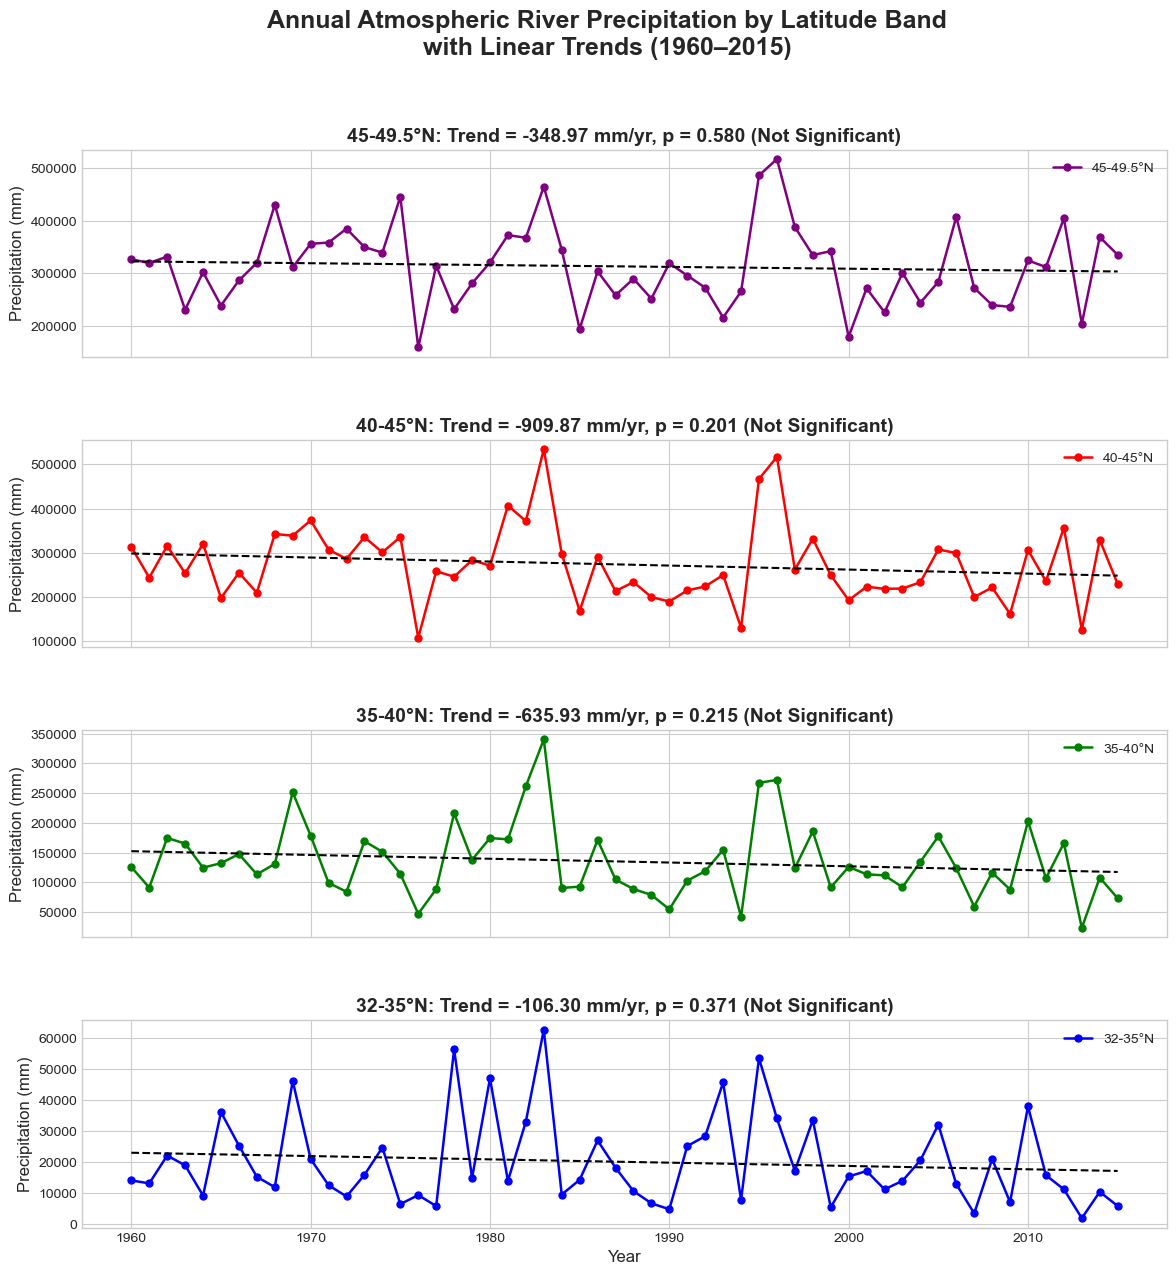

In [24]:

import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define latitude bands (north to south)
lat_bands = [(32, 35), (35, 40), (40, 45), (45, 49.5)]

# Create the dictionary to hold annual AR-day precipitation totals by latitude band
band_annual_precip = {}

for lat_min, lat_max in lat_bands:
    label = f"{lat_min}-{lat_max}°N"
    
    # Subset to this latitude band
    band_data = precip_ar_days['precip'].where(
        (precip_ar_days['lat'] >= lat_min) & (precip_ar_days['lat'] < lat_max)
    )
    
    # Group by year and sum over time, lat, lon
    annual_precip = band_data.groupby('time.year').sum(dim=['time', 'lat', 'lon']).compute()
    
    # Store in dictionary
    band_annual_precip[label] = annual_precip


# Define consistent style
plt.style.use('seaborn-v0_8-whitegrid')
font_main = {'fontsize': 18, 'fontweight': 'bold'}
font_sub = {'fontsize': 14, 'fontweight': 'bold'}

# Define latitude bands (north to south) and matching colors
lat_bands = [(32, 35), (35, 40), (40, 45), (45, 49.5)]
sorted_bands = [f"{lat_min}-{lat_max}°N" for lat_min, lat_max in lat_bands[::-1]]  # ["45-49.5°N", ..., "32-35°N"]
colors = ['purple', 'red', 'green', 'blue']

# Set up subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

# Loop through latitude bands
for i, label in enumerate(sorted_bands):
    ax = axs[i]
    precip = band_annual_precip[label]
    years = precip['year'].values
    values = precip.values

    # Plot actual values
    ax.plot(years, values, marker='o', color=colors[i], markersize=5, linewidth=1.8, label=f"{label}")

    # Add trendline
    slope, intercept, r_value, p_value, std_err = linregress(years, values)
    trend_line = intercept + slope * years
    ax.plot(years, trend_line, linestyle='--', color='black', linewidth=1.5)

    # Annotated label for trend
    sig_label = "(Significant)" if p_value < 0.05 else "(Not Significant)"
    ax.set_title(f"{label}: Trend = {slope:.2f} mm/yr, p = {p_value:.3f} {sig_label}", **font_sub)
    
    ax.set_ylabel("Precipitation (mm)", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.legend(loc='upper right', fontsize=10)

# Add x-label and title
axs[-1].set_xlabel("Year", fontsize=12)
fig.suptitle("Annual Atmospheric River Precipitation by Latitude Band\nwith Linear Trends (1960–2015)", **font_main)

# Adjust layout
plt.subplots_adjust(hspace=0.4)
plt.show()



## AR vs Non-AR Precipitation Analysis

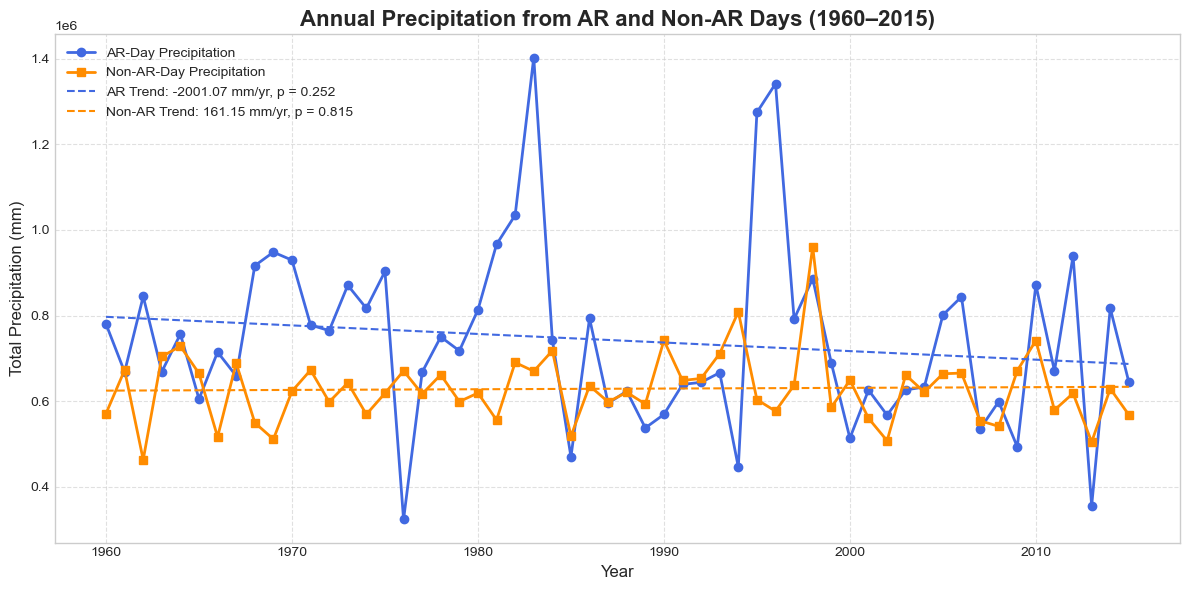

Mann-Kendall Trend Test Results:

AR Day Precipitation:
  Trend: no trend, Slope: -2287.41, p = 0.122

Non-AR Day Precipitation:
  Trend: no trend, Slope: -180.22, p = 0.729


In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import linregress
import pymannkendall as mk

# Prepare AR day mask 
all_dates = pd.to_datetime(ds_westcoast['time'].values)
ar_dates = pd.to_datetime(ar_catalog_filtered['time'].values).normalize()
ar_dates_unique = np.unique(ar_dates)
is_ar_day = np.isin(all_dates, ar_dates_unique)

# Mask AR and non-AR precipitation
precip = ds_westcoast['precip']
is_ar_day_expanded = xr.DataArray(is_ar_day, dims=['time'], coords={'time': precip['time']})

precip_ar = precip.where(is_ar_day_expanded)
precip_non_ar = precip.where(~is_ar_day_expanded)

# Aggregate annual totals 
precip_ar_annual = precip_ar.groupby('time.year').sum(dim=['time', 'lat', 'lon']).compute()
precip_non_ar_annual = precip_non_ar.groupby('time.year').sum(dim=['time', 'lat', 'lon']).compute()

years = precip_ar_annual['year'].values
ar_vals = precip_ar_annual.values
non_ar_vals = precip_non_ar_annual.values

# Calculate Linear trends 
slope_ar, intercept_ar, _, p_ar, _ = linregress(years, ar_vals)
slope_non_ar, intercept_non_ar, _, p_non_ar, _ = linregress(years, non_ar_vals)

trend_ar = intercept_ar + slope_ar * years
trend_non_ar = intercept_non_ar + slope_non_ar * years

# Create Plot
plt.figure(figsize=(12, 6))
plt.plot(years, ar_vals, label='AR-Day Precipitation', color='royalblue', marker='o', linewidth=2)
plt.plot(years, non_ar_vals, label='Non-AR-Day Precipitation', color='darkorange', marker='s', linewidth=2)

plt.plot(years, trend_ar, linestyle='--', color='royalblue',
         label=f"AR Trend: {slope_ar:.2f} mm/yr, p = {p_ar:.3f}")
plt.plot(years, trend_non_ar, linestyle='--', color='darkorange',
         label=f"Non-AR Trend: {slope_non_ar:.2f} mm/yr, p = {p_non_ar:.3f}")

plt.title("Annual Precipitation from AR and Non-AR Days (1960–2015)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Precipitation (mm)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Mann-Kendall Test Results
print("Mann-Kendall Trend Test Results:\n")

result_ar = mk.original_test(ar_vals)
print("AR Day Precipitation:")
print(f"  Trend: {result_ar.trend}, Slope: {result_ar.slope:.2f}, p = {result_ar.p:.3f}")

result_non_ar = mk.original_test(non_ar_vals)
print("\nNon-AR Day Precipitation:")
print(f"  Trend: {result_non_ar.trend}, Slope: {result_non_ar.slope:.2f}, p = {result_non_ar.p:.3f}")


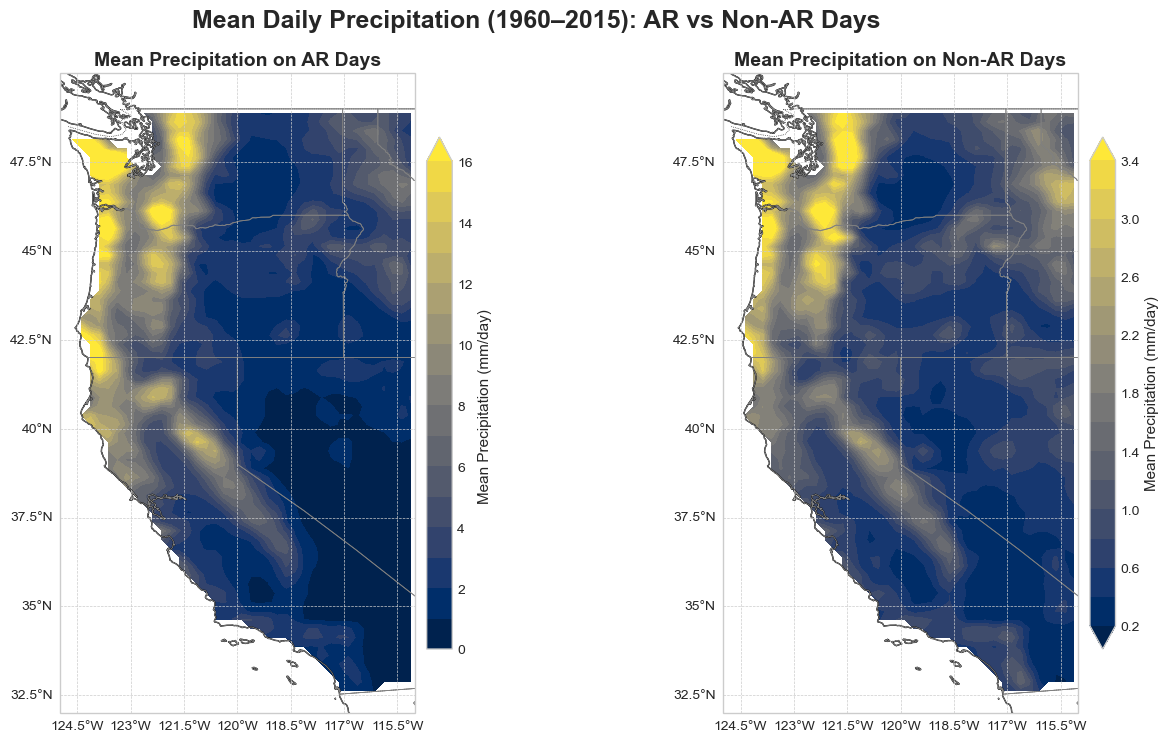

In [26]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

# Compute mean daily precipitation on AR and Non-AR days
mean_precip_ar = precip_ar.mean(dim='time')
mean_precip_non_ar = precip_non_ar.mean(dim='time')

# Create land mask
land_regions = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask_ar = land_regions.mask(mean_precip_ar)
land_mask_non_ar = land_regions.mask(mean_precip_non_ar)

# Apply land mask
mean_precip_ar_land = mean_precip_ar.where(~np.isnan(land_mask_ar))
mean_precip_non_ar_land = mean_precip_non_ar.where(~np.isnan(land_mask_non_ar))


fig, axs = plt.subplots(ncols=2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

titles = ["Mean Precipitation on AR Days", "Mean Precipitation on Non-AR Days"]
data_arrays = [mean_precip_ar_land, mean_precip_non_ar_land]

# Define consistent contour levels
contour_levels = 20
colormap = 'cividis'

for i, (ax, data, title) in enumerate(zip(axs, data_arrays, titles)):
    # Main contourf plot
    pcm = data.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=colormap,
        levels=contour_levels,
        robust=True,
        add_colorbar=False
    )

    # Add individual colorbars
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
    cbar.set_label('Mean Precipitation (mm/day)', fontsize=11)

    ax.set_extent([-125, -115, 32, 50])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.6)
    ax.set_title(title, fontsize=14, fontweight='bold')

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Title above both plots
fig.suptitle("Mean Daily Precipitation (1960–2015): AR vs Non-AR Days", fontsize=18, fontweight='bold')
fig.subplots_adjust(wspace=0.15, top=0.9, bottom=0.1)

plt.show()


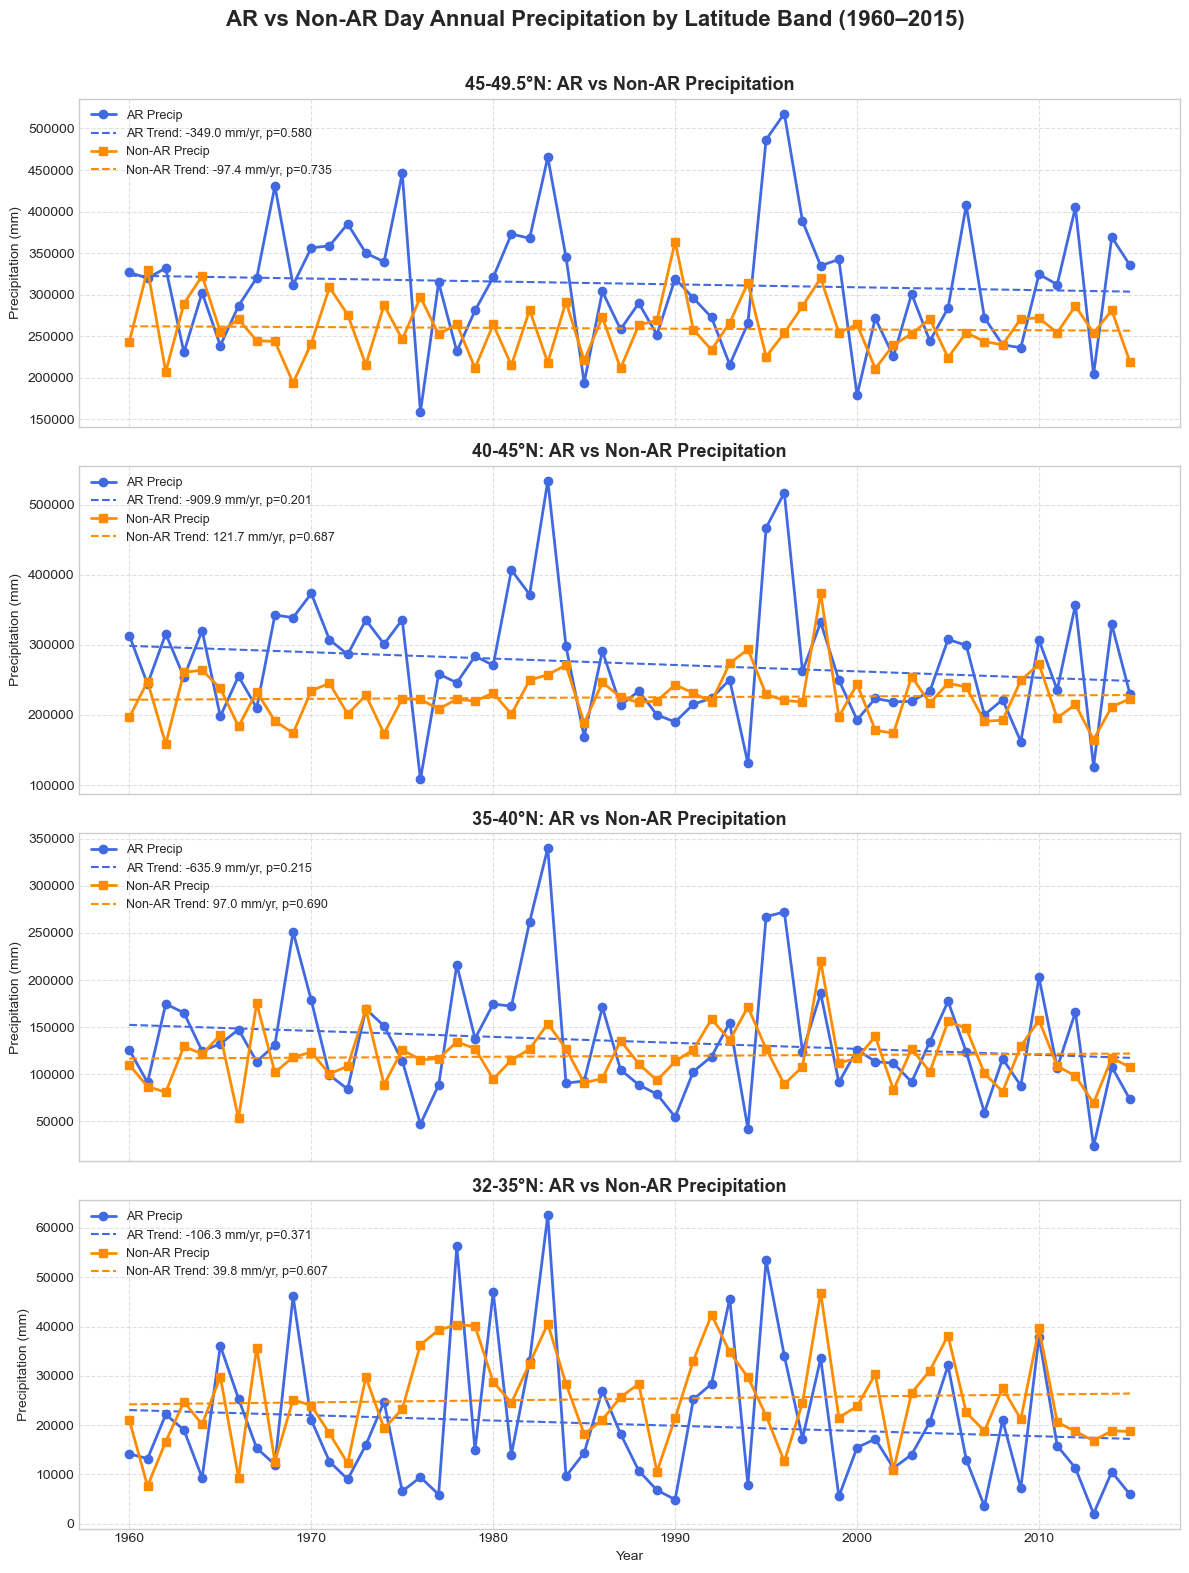

Mann-Kendall Trend Test Results by Latitude Band:

32-35°N:
  AR Day Precip → Trend: no trend, Slope: -107.78, p = 0.227
  Non-AR Day Precip → Trend: no trend, Slope: 13.83, p = 0.838

35-40°N:
  AR Day Precip → Trend: no trend, Slope: -581.78, p = 0.155
  Non-AR Day Precip → Trend: no trend, Slope: 57.09, p = 0.805

40-45°N:
  AR Day Precip → Trend: no trend, Slope: -1066.37, p = 0.089
  Non-AR Day Precip → Trend: no trend, Slope: -76.11, p = 0.849

45-49.5°N:
  AR Day Precip → Trend: no trend, Slope: -531.50, p = 0.441
  Non-AR Day Precip → Trend: no trend, Slope: -37.53, p = 0.860



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pymannkendall as mk
import xarray as xr
import pandas as pd

# AR Date Setup
all_dates = pd.to_datetime(ds_westcoast['time'].values)
ar_dates = pd.to_datetime(ar_catalog_filtered['time'].values).normalize()
ar_dates_unique = np.unique(ar_dates)
is_ar_day = np.isin(all_dates, ar_dates_unique)

# Expand mask and define precipitation DataArrays
precip = ds_westcoast['precip']
is_ar_day_expanded = xr.DataArray(is_ar_day, dims=['time'], coords={'time': precip['time']})

precip_ar = precip.where(is_ar_day_expanded)
precip_non_ar = precip.where(~is_ar_day_expanded)

# Latitude Bands Setup
lat_bands = [(32, 35), (35, 40), (40, 45), (45, 49.5)]
band_labels = [f"{lo}-{hi}°N" for lo, hi in lat_bands]
colors = ['blue', 'green', 'red', 'purple']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=True)

for i, ((lat_min, lat_max), label) in enumerate(zip(lat_bands[::-1], band_labels[::-1])):
    ax = axs[i]
    
    # Mask data for this latitude band
    ar_band = precip_ar.where((precip['lat'] >= lat_min) & (precip['lat'] < lat_max))
    non_ar_band = precip_non_ar.where((precip['lat'] >= lat_min) & (precip['lat'] < lat_max))

    # Initialize dictionaries
    ar_annual_dict = {}
    non_ar_annual_dict = {}

    # Extract all unique years
    all_years = np.unique(precip['time.year'])

    for year in all_years:
        # Subset by year
        yearly_ar = ar_band.sel(time=ar_band['time.year'] == year)
        yearly_non_ar = non_ar_band.sel(time=non_ar_band['time.year'] == year)

        # Compute total precip
        ar_sum = yearly_ar.sum(dim=['time', 'lat', 'lon']).compute().item()
        non_ar_sum = yearly_non_ar.sum(dim=['time', 'lat', 'lon']).compute().item()

        ar_annual_dict[year] = ar_sum
        non_ar_annual_dict[year] = non_ar_sum

    # Convert to Series
    ar_series = pd.Series(ar_annual_dict).sort_index()
    non_ar_series = pd.Series(non_ar_annual_dict).sort_index()
    years = ar_series.index.values
    ar_vals = ar_series.values
    non_ar_vals = non_ar_series.values

    # Linear regression
    slope_ar, intercept_ar, _, p_ar, _ = linregress(years, ar_vals)
    slope_non_ar, intercept_non_ar, _, p_non_ar, _ = linregress(years, non_ar_vals)

    trend_ar = intercept_ar + slope_ar * years
    trend_non_ar = intercept_non_ar + slope_non_ar * years

    # Plot
    ax.plot(years, ar_vals, marker='o', color='royalblue', linewidth=2, label="AR Precip")
    ax.plot(years, trend_ar, linestyle='--', color='royalblue',
            label=f"AR Trend: {slope_ar:.1f} mm/yr, p={p_ar:.3f}")
    
    ax.plot(years, non_ar_vals, marker='s', color='darkorange', linewidth=2, label="Non-AR Precip")
    ax.plot(years, trend_non_ar, linestyle='--', color='darkorange',
            label=f"Non-AR Trend: {slope_non_ar:.1f} mm/yr, p={p_non_ar:.3f}")
    
    ax.set_title(f"{label}: AR vs Non-AR Precipitation", fontsize=13, fontweight='bold')
    ax.set_ylabel("Precipitation (mm)")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc='upper left', fontsize=9)

axs[-1].set_xlabel("Year")
plt.suptitle("AR vs Non-AR Day Annual Precipitation by Latitude Band (1960–2015)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Mann-Kendall Tests
print("Mann-Kendall Trend Test Results by Latitude Band:\n")
for (lat_min, lat_max), label in zip(lat_bands, band_labels):
    # Mask again
    ar_band = precip_ar.where((precip['lat'] >= lat_min) & (precip['lat'] < lat_max))
    non_ar_band = precip_non_ar.where((precip['lat'] >= lat_min) & (precip['lat'] < lat_max))

    ar_dict, non_ar_dict = {}, {}
    for year in all_years:
        ar_sum = ar_band.sel(time=ar_band['time.year'] == year).sum(dim=['time', 'lat', 'lon']).compute().item()
        non_ar_sum = non_ar_band.sel(time=non_ar_band['time.year'] == year).sum(dim=['time', 'lat', 'lon']).compute().item()
        ar_dict[year] = ar_sum
        non_ar_dict[year] = non_ar_sum

    ar_vals = pd.Series(ar_dict).sort_index().values
    non_ar_vals = pd.Series(non_ar_dict).sort_index().values

    result_ar = mk.original_test(ar_vals)
    result_non_ar = mk.original_test(non_ar_vals)

    print(f"{label}:")
    print(f"  AR Day Precip → Trend: {result_ar.trend}, Slope: {result_ar.slope:.2f}, p = {result_ar.p:.3f}")
    print(f"  Non-AR Day Precip → Trend: {result_non_ar.trend}, Slope: {result_non_ar.slope:.2f}, p = {result_non_ar.p:.3f}\n")



## % of Annual Precip from ARs Analysis

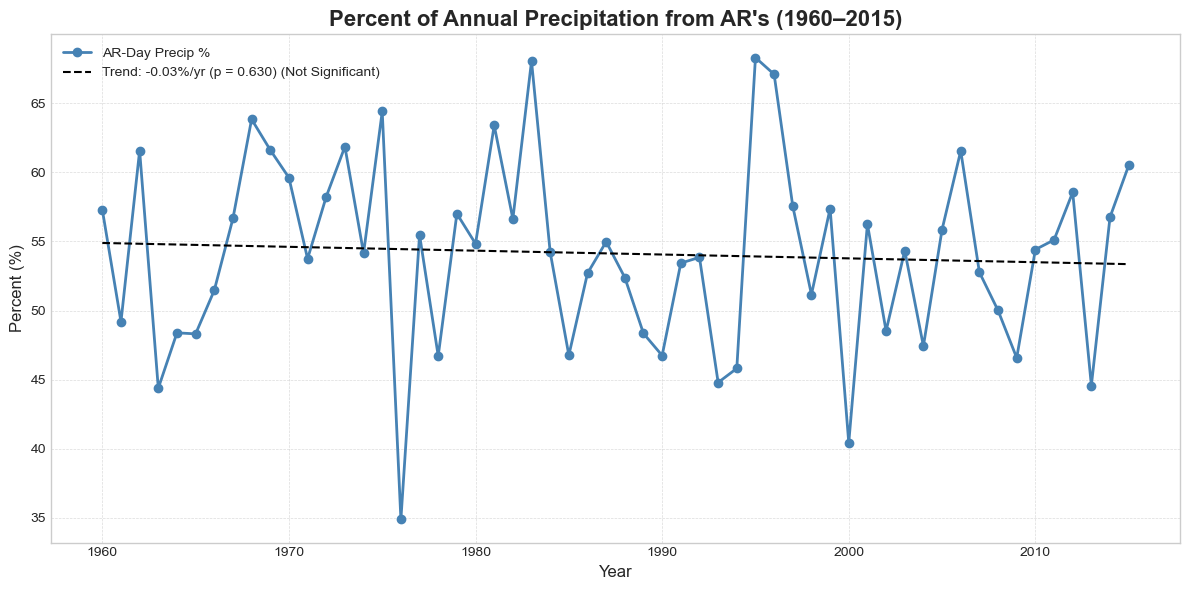

Trend Summary:
  Linear Regression: (Not Significant) — Slope = -0.028, p = 0.6298
  Mann-Kendall:      (Not Significant) — Trend = no trend, Slope = -0.0350, p = 0.5575


In [28]:

import matplotlib.pyplot as plt
from scipy.stats import linregress
import pymannkendall as mk
import numpy as np

years = np.arange(1960, 2016)  # or based on the AR catalog filter

# Ensure both are NumPy arrays
ar_vals = np.array(ar_vals)
non_ar_vals = np.array(non_ar_vals)

# Compute percent of annual precip from AR days
percent_vals = (ar_vals / (ar_vals + non_ar_vals)) * 100

# Linear Regression
slope, intercept, r_value, p_value, _ = linregress(years, percent_vals)
trend_line = intercept + slope * years

# Mann-Kendall Test
mk_result = mk.original_test(percent_vals)

# Significance Labels
sig_label = "(Significant)" if p_value < 0.05 else "(Not Significant)"
mk_sig_label = "(Significant)" if mk_result.p < 0.05 else "(Not Significant)"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(years, percent_vals, marker='o', color='steelblue', linewidth=2, label='AR-Day Precip %')
ax.plot(years, trend_line, linestyle='--', color='black',
        label=f"Trend: {slope:.2f}%/yr (p = {p_value:.3f}) {sig_label}")

ax.set_title("Percent of Annual Precipitation from AR's (1960–2015)", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Percent (%)", fontsize=12)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Print Summary
print("Trend Summary:")
print(f"  Linear Regression: {sig_label} — Slope = {slope:.3f}, p = {p_value:.4f}")
print(f"  Mann-Kendall:      {mk_sig_label} — Trend = {mk_result.trend}, Slope = {mk_result.slope:.4f}, p = {mk_result.p:.4f}")


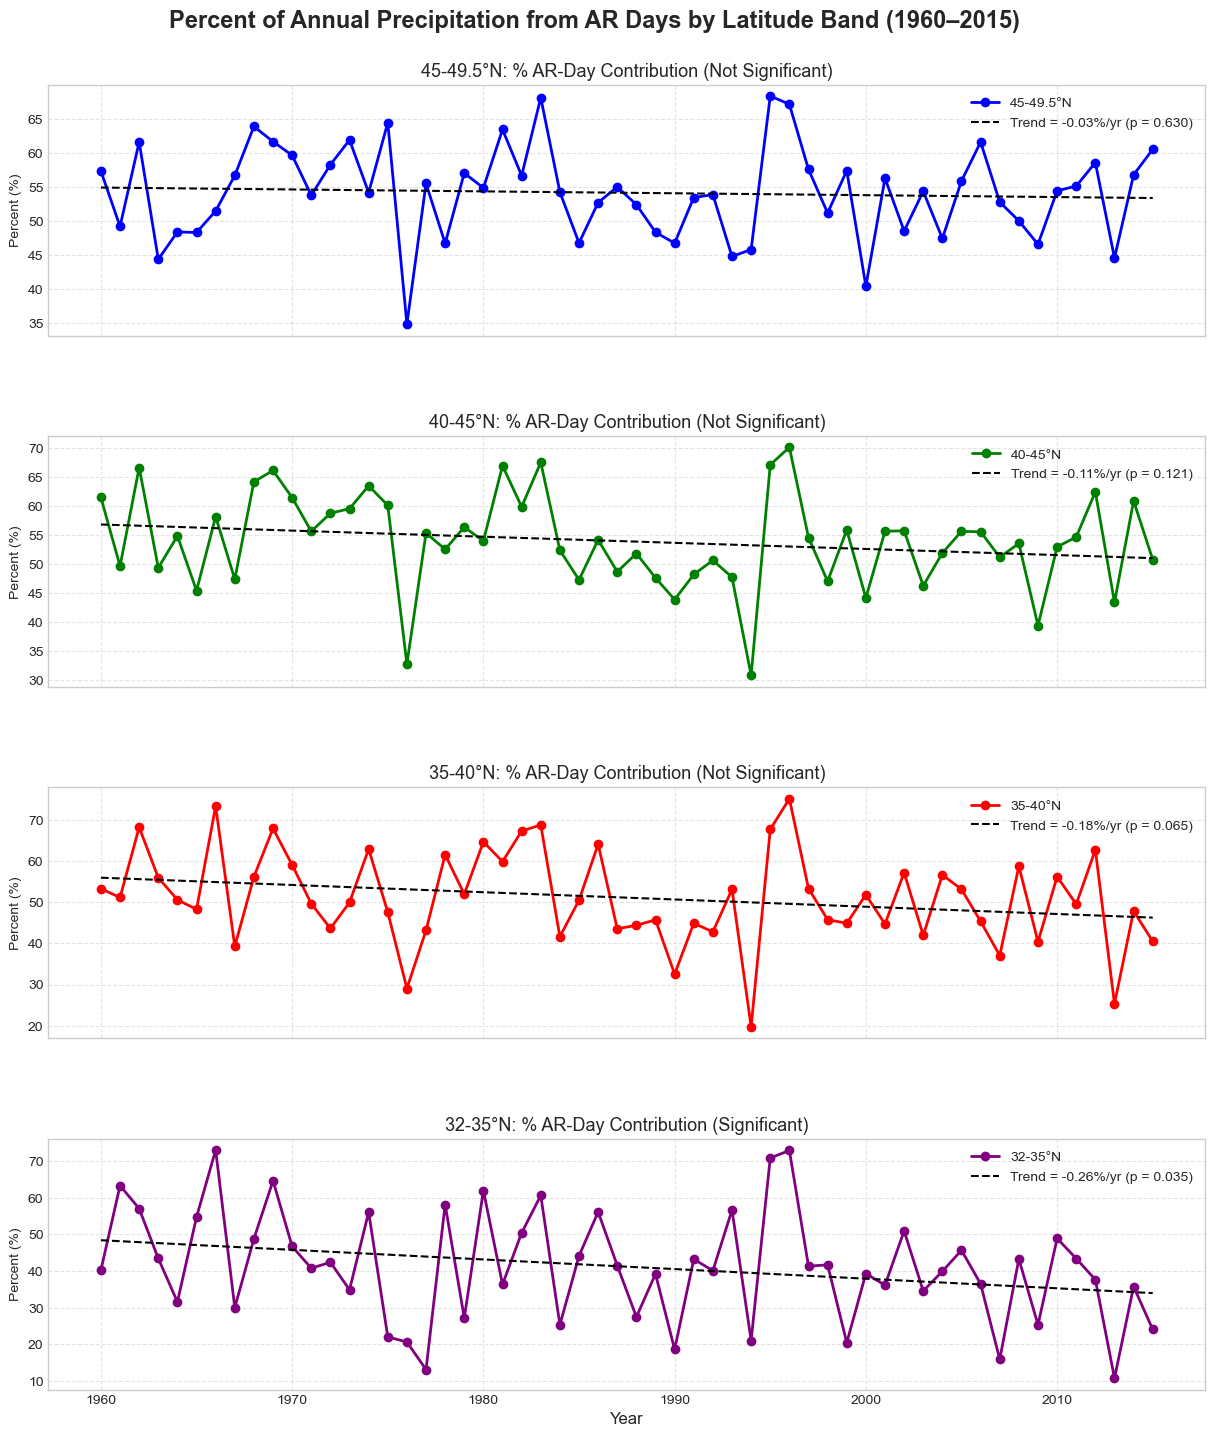

45-49.5°N: Mann-Kendall Trend = no trend, Slope = -0.0350, p = 0.5575
40-45°N: Mann-Kendall Trend = no trend, Slope = -0.1191, p = 0.0784
35-40°N: Mann-Kendall Trend = no trend, Slope = -0.1690, p = 0.0784
32-35°N: Mann-Kendall Trend = decreasing, Slope = -0.2749, p = 0.0290


In [29]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pymannkendall import original_test as mk_test  

lat_bands = [(32, 35), (35, 40), (40, 45), (45, 49.5)]
band_labels = [f"{lo}-{hi}°N" for lo, hi in lat_bands]

percent_by_band = {}

for (lat_min, lat_max), label in zip(lat_bands, band_labels):
    # Subset to the latitude band
    ar_band = precip_ar.where((precip_ar['lat'] >= lat_min) & (precip_ar['lat'] < lat_max))
    non_ar_band = precip_non_ar.where((precip_non_ar['lat'] >= lat_min) & (precip_non_ar['lat'] < lat_max))

    # Sum AR and non-AR precip by year
    ar_annual = ar_band.groupby('time.year').sum(dim=['time', 'lat', 'lon']).compute()
    non_annual = non_ar_band.groupby('time.year').sum(dim=['time', 'lat', 'lon']).compute()

    # Compute percent of total annual precip from ARs
    percent = (ar_annual / (ar_annual + non_annual)) * 100

    # Store in dictionary
    percent_by_band[label] = percent


colors = ['blue', 'green', 'red', 'purple']
band_labels = list(percent_by_band.keys())[::-1]  # North to south
years = percent_by_band[band_labels[0]]['year'].values

fig, axs = plt.subplots(nrows=4, figsize=(13, 15), sharex=True)

for i, label in enumerate(band_labels):
    values = percent_by_band[label].values
    ax = axs[i]

    # Line plot
    ax.plot(years, values, marker='o', color=colors[i], linewidth=2, label=f"{label}")

    # Linear regression
    slope, intercept, r, p, std_err = linregress(years, values)
    trend_line = intercept + slope * years
    ax.plot(years, trend_line, linestyle='--', color='black',
            label=f"Trend = {slope:.2f}%/yr (p = {p:.3f})")

    # Annotation
    sig = "(Significant)" if p < 0.05 else "(Not Significant)"
    ax.set_title(f"{label}: % AR-Day Contribution {sig}", fontsize=13)
    ax.set_ylabel("Percent (%)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=10)

axs[-1].set_xlabel("Year", fontsize=12)
fig.suptitle("Percent of Annual Precipitation from AR Days by Latitude Band (1960–2015)",
             fontsize=17, fontweight='bold')
fig.subplots_adjust(left=0.08, right=0.97, top=0.93, bottom=0.06, hspace=0.4)
plt.show()

# Print Mann-Kendall results
for label in band_labels:
    result = mk_test(percent_by_band[label].values)
    print(f"{label}: Mann-Kendall Trend = {result.trend}, Slope = {result.slope:.4f}, p = {result.p:.4f}")



## Extreme Precipitation Analysis

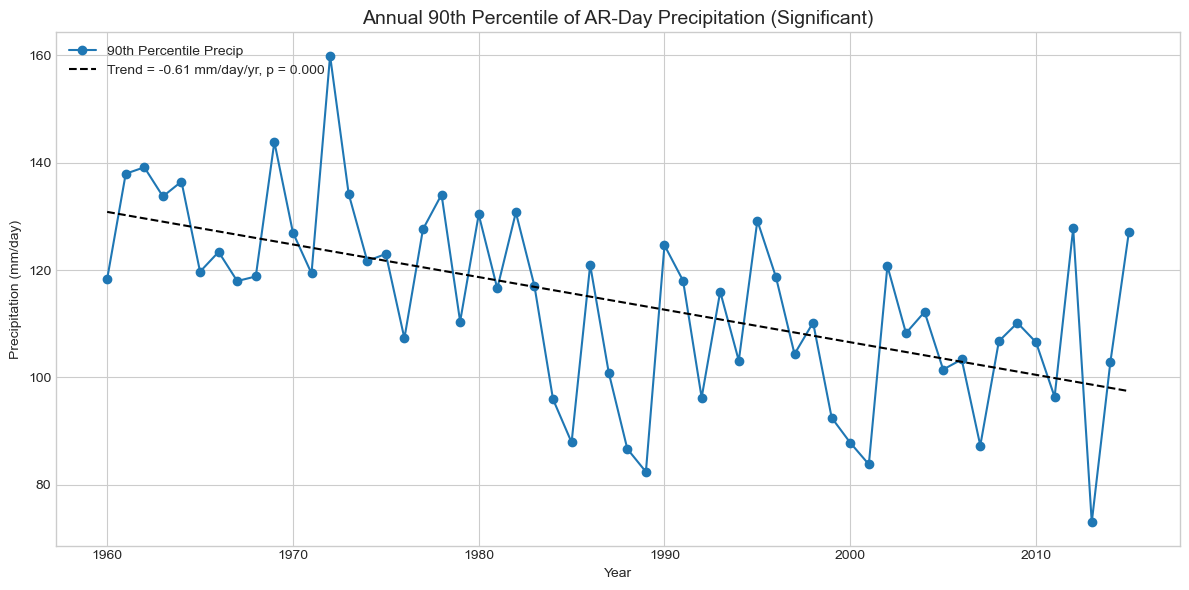

90th Percentile Trend Statistics:
  Linear Regression Slope: -0.61 mm/day/year
  Linear Regression p-value: 0.0000
  Mann-Kendall Trend: decreasing
  Mann-Kendall Slope: -0.6104 mm/day/year
  Mann-Kendall p-value: 0.0000


In [30]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pymannkendall import original_test as mk_test

# Compute 90th percentile of max daily AR precipitation for each year
percentile_values = []
years = np.arange(1960, 2016)

for year in years:
    year_data = precip_ar_days.sel(time=str(year))['precip']
    daily_max = year_data.max(dim=['lat', 'lon'])  # max precip per day
    p90 = np.nanpercentile(daily_max, 90)  # use nan-aware version
    percentile_values.append(p90)

# Convert to arrays and filter out NaNs
years_arr = np.array(years)
p90_arr = np.array(percentile_values)
mask = ~np.isnan(p90_arr)
years_clean = years_arr[mask]
p90_clean = p90_arr[mask]

# Linear regression
slope, intercept, r, p, std_err = linregress(years_clean, p90_clean)
trend_line = intercept + slope * years_clean

# Mann-Kendall test
mk = mk_test(p90_clean)
significance = "Significant" if mk.p < 0.05 else "Not Significant"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years_clean, p90_clean, marker='o', label='90th Percentile Precip')
ax.plot(years_clean, trend_line, linestyle='--', color='black',
        label=f"Trend = {slope:.2f} mm/day/yr, p = {p:.3f}")
ax.set_title(f"Annual 90th Percentile of AR-Day Precipitation ({significance})", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Precipitation (mm/day)")
ax.grid(True)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Output results
print("90th Percentile Trend Statistics:")
print(f"  Linear Regression Slope: {slope:.2f} mm/day/year")
print(f"  Linear Regression p-value: {p:.4f}")
print(f"  Mann-Kendall Trend: {mk.trend}")
print(f"  Mann-Kendall Slope: {mk.slope:.4f} mm/day/year")
print(f"  Mann-Kendall p-value: {mk.p:.4f}")



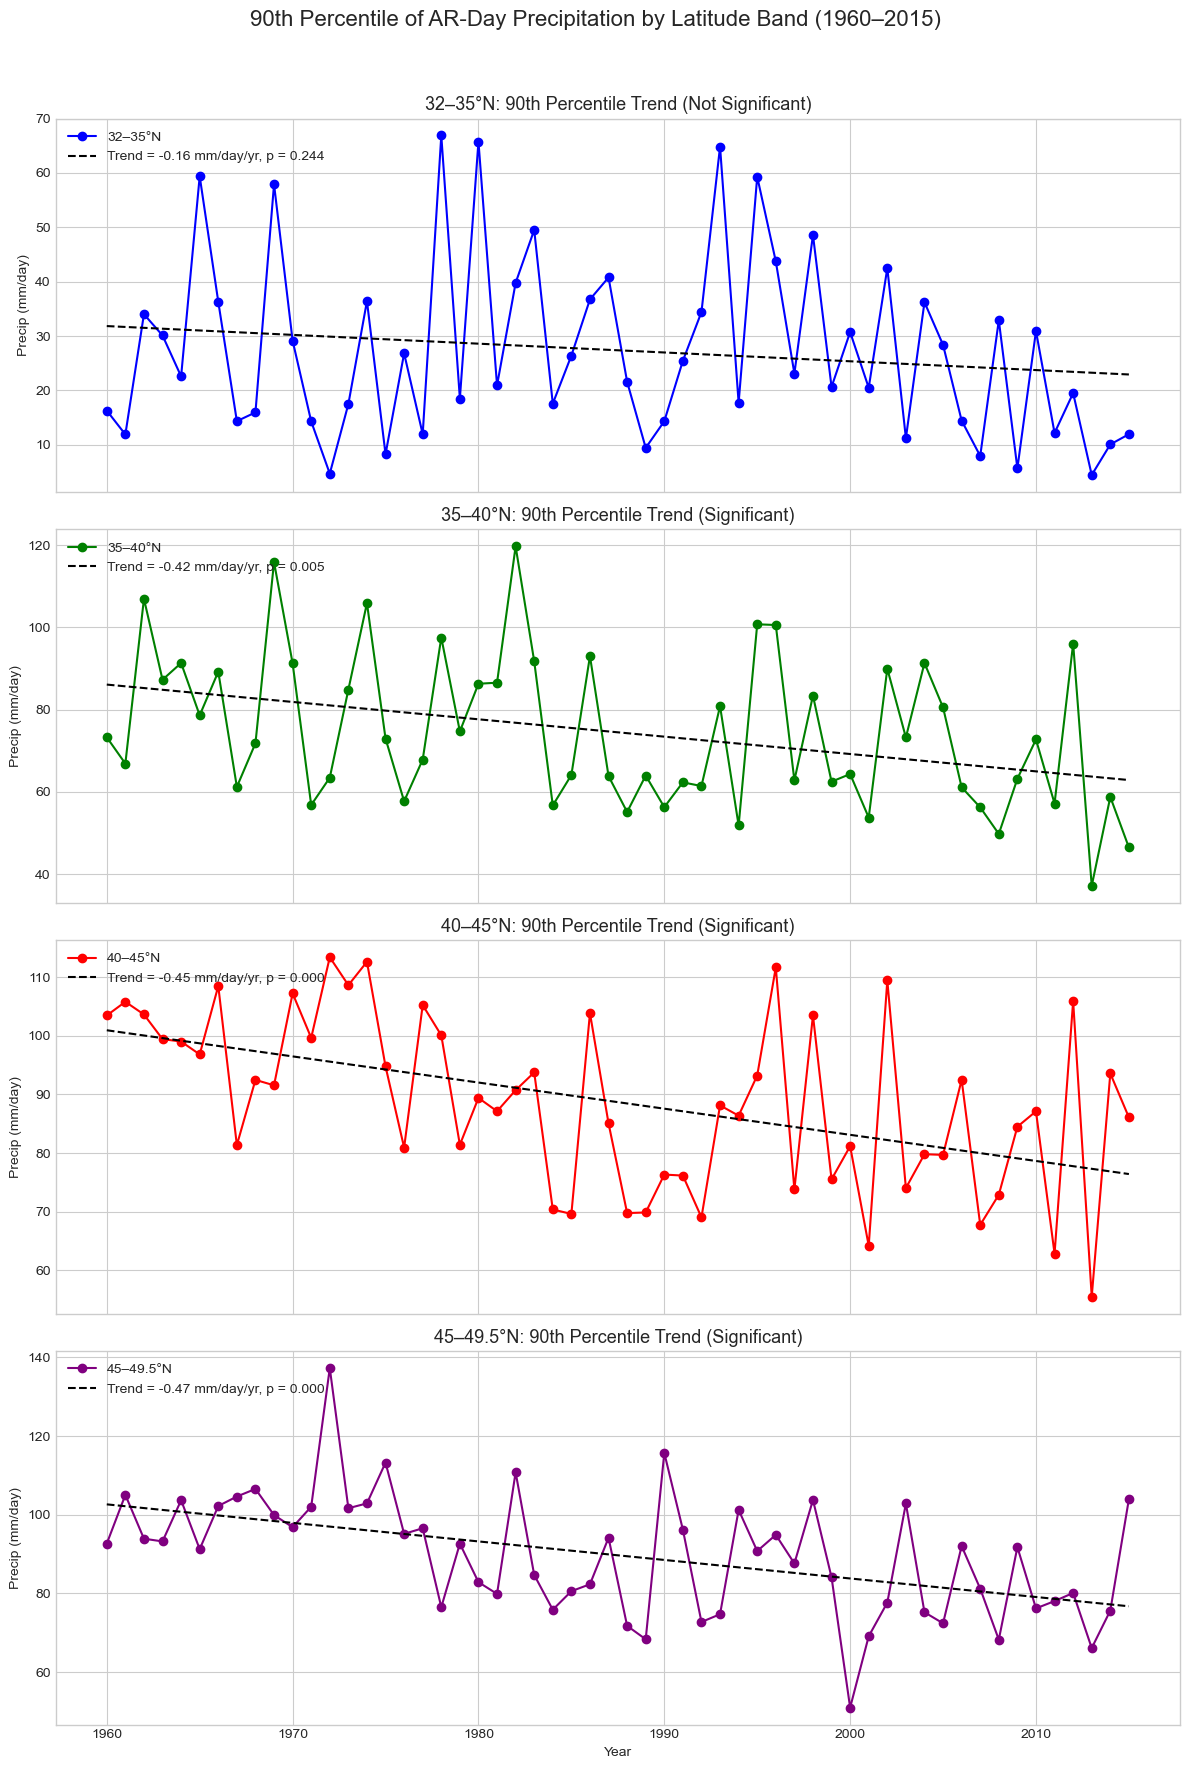

In [31]:

from scipy.stats import linregress
from pymannkendall import original_test as mk_test
import matplotlib.pyplot as plt
import numpy as np

# Define latitude bands
lat_bands = [(32, 35), (35, 40), (40, 45), (45, 49.5)]
band_labels = [f"{lat_min}–{lat_max}°N" for lat_min, lat_max in lat_bands]
colors = ['blue', 'green', 'red', 'purple']

# Prepare subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 18), sharex=True)

# Year range
years = np.arange(1960, 2016)

# Loop through each band
for i, ((lat_min, lat_max), label) in enumerate(zip(lat_bands, band_labels)):
    # Subset AR-day precip to band
    band_precip = precip_ar_days['precip'].where(
        (precip_ar_days['lat'] >= lat_min) & (precip_ar_days['lat'] < lat_max)
    )

    # Calculate 90th percentile of daily max precip per year
    p90_list = []
    for year in years:
        year_data = band_precip.sel(time=str(year))
        daily_max = year_data.max(dim=['lat', 'lon'])
        if np.all(np.isnan(daily_max)):
            p90 = np.nan
        else:
            p90 = np.nanpercentile(daily_max, 90)
        p90_list.append(p90)

    # Clean NaNs
    years_clean = np.array(years)
    p90_arr = np.array(p90_list)
    mask = ~np.isnan(p90_arr)
    years_filtered = years_clean[mask]
    values_filtered = p90_arr[mask]

    # Regression
    slope, intercept, r, p, std_err = linregress(years_filtered, values_filtered)
    trend_line = intercept + slope * years_filtered

    # Mann-Kendall
    mk = mk_test(values_filtered)
    sig = "(Significant)" if mk.p < 0.05 else "(Not Significant)"

    # Plot
    ax = axs[i]
    ax.plot(years_filtered, values_filtered, marker='o', color=colors[i], label=label)
    ax.plot(years_filtered, trend_line, linestyle='--', color='black',
            label=f"Trend = {slope:.2f} mm/day/yr, p = {p:.3f}")
    ax.set_title(f"{label}: 90th Percentile Trend {sig}", fontsize=13)
    ax.set_ylabel("Precip (mm/day)")
    ax.grid(True)
    ax.legend(loc='upper left')

axs[-1].set_xlabel("Year")
plt.suptitle("90th Percentile of AR-Day Precipitation by Latitude Band (1960–2015)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()